In [1]:
import numpy as np
import matplotlib.pylab as plt
import re
from tables import open_file
from statistics import median, mode
from scipy.optimize import curve_fit, minimize
from math import acos, degrees, log
from matplotlib.colors import LogNorm

class clean(object):
    def __init__(self, file_name):
        self.file_name = file_name
        self.file_path = '/Users/cosmos2299/documents/data/'
        l = open_file(self.file_path + self.file_name)
        list(l)
    
        self.atstamp = l.root.absolute_timestamp[150:].flatten()
        self.r_0 = l.root.rising_0[150:].flatten()
        self.r_1 = l.root.rising_1[150:].flatten()
        self.r_2 = l.root.rising_2[150:].flatten()
        self.r_3 = l.root.rising_3[150:].flatten()
        self.f_0 = l.root.falling_0[150:].flatten()
        self.f_1 = l.root.falling_1[150:].flatten()
        self.f_2 = l.root.falling_3[150:].flatten()
        self.f_3 = l.root.falling_3[150:].flatten()
    
        self.p_jumps = ((self.atstamp.size - self.atstamp[(self.atstamp < 1e11) & (self.atstamp > -1e7)].size)/
                     self.atstamp.size) * 100
        print('percentage of high jumps in the file -', self.p_jumps)
    
    #POCAM, sDOM, PMT, LED and voltage used
    def P_S_used(self):                                         
        POCAM_re = re.compile('P[1-2]')
        SDOM_re = re.compile('SDOM[1-5]')
        frequency_re = re.compile('[0-9][0-9][0-9][0-9]Hz')
        voltage_re = re.compile('[0-9][0-9]V')
        flash_time_re = re.compile('[0-9][0-9]s')
        LED_re = re.compile('P[0-9]_[a-z]')
        PMT_re = re.compile('hld_[a-z]')

        self.SDOM_num = SDOM_re.findall(self.file_name)
        self.POCAM_num = POCAM_re.findall(self.file_name)
        frequency = frequency_re.findall(self.file_name)
        voltage = voltage_re.findall(self.file_name)
        flash_time = flash_time_re.findall(self.file_name)
        LED = LED_re.findall(self.file_name)
        PMT = PMT_re.findall(self.file_name)
    
        if PMT == ['hld_d']:
            self.PMT = 'down'
        else:
            self.PMT = 'up'
    
        if LED == ['P1_b']:
            LED = 'blue'
        if LED == ['P1_v']:
            LED = 'violet'
    
        if LED == ['P2_b']:
            LED = 'blue'
        if LED == ['P2_v']:
            LED = 'violet'
        
        graph_title = [self.POCAM_num, self.SDOM_num, self.PMT, LED, voltage]
        values = ','.join(str(v) for v in graph_title)
         
    #timestamp graph
        plt.figure(figsize=(10,9))
        plt.title(values, fontsize = 22)
        plt.ylabel('absolute_timestamps(ns)', fontsize = 19)
        plt.xlabel('index', fontsize = 19)
        plt.plot(self.atstamp, '.')
        plt.savefig(self.file_path + '/graphs/' + values + 'high_jumps.jpeg', dpi = 200)
    
    #cleaning large jumps
        elim_h_jumps = (self.atstamp < 1e11) & (self.atstamp > -1e7)
        abs_elim = self.atstamp[elim_h_jumps]
        rising_0_elim = self.r_0[elim_h_jumps]
        rising_1_elim = self.r_1[elim_h_jumps]
        rising_2_elim = self.r_2[elim_h_jumps]
        rising_3_elim = self.r_3[elim_h_jumps]
        falling_0_elim = self.f_0[elim_h_jumps]
        falling_1_elim = self.f_1[elim_h_jumps]
        falling_2_elim = self.f_2[elim_h_jumps]
        falling_3_elim = self.f_3[elim_h_jumps]
    
        plt.figure(figsize=(10,9))
        plt.title(values, fontsize = 22)
        plt.ylabel('absolute_timestamp(ns)', fontsize = 19)
        plt.xlabel('index', fontsize = 19)
        plt.plot(abs_elim, '.')
        plt.savefig(self.file_path + '/graphs/' + values + 'high_jumps_cleaned.jpeg', dpi = 200)
        plt.show()
   
        plt.figure(figsize=(10,9))
        plt.title(values + ' Negative Timestamps', fontsize = 18)
        plt.ylabel('absolute_timestamp(ns)', fontsize = 19)
        plt.plot(abs_elim, '.')
        plt.ylim(-1e7, 0)
        plt.savefig(self.file_path + '/graphs/' + values + 'negative_values.jpeg', dpi = 200)
        plt.show()

    #time difference graph
        abs_elim_diff = abs_elim[1:] - abs_elim[:-1]
    
        abs_elim_bool = abs_elim[:-1][abs_elim_diff < 0]
    
        plt.figure(figsize=(10,9))
        plt.title(values, fontsize = 22)
        plt.ylabel('absolute_timestamp difference(ns)', fontsize = 19)
        plt.xlabel('index', fontsize = 19)
        plt.plot(abs_elim_diff, '.')
        plt.savefig(self.file_path + '/graphs/' + values + 'timestamp_differences.jpeg', dpi = 200)
        plt.show()
    
        if abs_elim_bool.size != 0:
            plt.figure(figsize=(10,9))
            plt.ylabel('absolute_timestamp(ns)', fontsize = 19)
            plt.xlabel('index', fontsize = 19)
            plt.title(values + ' Jumps in Timestamps', fontsize = 16)
            plt.plot(abs_elim[abs_elim_diff.argmin()-10:abs_elim_diff.argmin()+10], '.')
            plt.savefig(self.file_path + '/graphs/' + values + 'small_jumps.jpeg', dpi = 200)
            plt.show()
    
    #cleaning small jumps
        abs_elim_diff_2 = abs_elim[1:] - abs_elim[:-1]
    
        s_jump_index = []
        s_jump_1 = []
        s_jump_2 = []
        list_1 = np.array([])

        for r in range(0, abs_elim_diff_2.size):
            if abs_elim_diff_2[r] < 0:
                s_jump_index.append(r)
                s_jump_1.append(abs_elim_diff_2[r])

        for t in range(0, len(s_jump_index)):
            select = abs_elim_diff_2[s_jump_index[t] - 10:s_jump_index[t]]
            x = s_jump_index[t] - (10 - (np.abs(select+abs_elim_diff_2[s_jump_index[t]])).argmin())
            jump_length = s_jump_index[t] - x
    
            if jump_length == 1:
                list_1 = np.append(list_1, [x+1])
            if jump_length == 2:
                list_1 = np.append(list_1,[x+1, x+2])
            if jump_length == 3:
                list_1 = np.append(list_1,[x+1, x+2, x+3])
            if jump_length == 4:
                list_1 = np.append(list_1,[x+1, x+2, x+3, x+4])
            if jump_length == 5:
                list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5])
            if jump_length == 6:
                list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5, x+6])
            if jump_length == 7:
                list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5, x+6, x+7])
            if jump_length == 8:
                list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5, x+6, x+7, x+8])
            if jump_length == 9:
                list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5, x+6, x+7, x+8, x+9])
            if jump_length == 10:
                list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5, x+6, x+7, x+8, x+9, x+10])
   
        print(list_1)
    
        abs_elim_3e = np.delete(abs_elim, list_1)
        self.abs_elim_diff_3 = abs_elim_3e[1:] - abs_elim_3e[:-1]
        
        rising_0_elim_3e = np.delete(rising_0_elim, list_1)
        rising_1_elim_3e = np.delete(rising_1_elim, list_1)
        rising_2_elim_3e = np.delete(rising_2_elim, list_1)
        rising_3_elim_3e = np.delete(rising_3_elim, list_1)
        falling_0_elim_3e = np.delete(falling_0_elim, list_1)
        falling_1_elim_3e = np.delete(falling_1_elim, list_1)
        falling_2_elim_3e = np.delete(falling_2_elim, list_1)
        falling_3_elim_3e = np.delete(falling_3_elim, list_1)
        
        plt.figure(figsize=(10,9))
        plt.title(graph_title, fontsize = 22)
        plt.ylabel('absolute_timestamp difference(ns)', fontsize = 19)
        plt.xlabel('index', fontsize = 19)
        #plt.ylim(-10000, 0)
        plt.plot(self.abs_elim_diff_3, '.')
        plt.savefig(self.file_path + '/graphs/' + values + 'small_jumps_cleaned.jpeg', dpi = 200)
        plt.show()
        
        dt_mean = (abs_elim_3e[1:] - abs_elim_3e[:-1]).mean()
        
        #cleaning faulty falling time events
        boolean = ((falling_0_elim_3e != 0) & ((falling_1_elim_3e - rising_1_elim_3e) >= 0) & 
                   ((falling_2_elim_3e - rising_2_elim_3e) >= 0) & ((falling_3_elim_3e - rising_3_elim_3e) >= 0))
        abs_elim_3 = abs_elim_3e[boolean]
        rising_0_elim_3 = rising_0_elim_3e[boolean]
        rising_1_elim_3 = rising_1_elim_3e[boolean]
        rising_2_elim_3 = rising_2_elim_3e[boolean]
        rising_3_elim_3 = rising_3_elim_3e[boolean]
        falling_0_elim_3 = falling_0_elim_3e[boolean] 
        falling_1_elim_3 = falling_1_elim_3e[boolean]
        falling_2_elim_3 = falling_2_elim_3e[boolean]
        falling_3_elim_3 = falling_3_elim_3e[boolean]
        
        #cleaning faulty falling time events
        delete = []
        for i in range(0, abs_elim_3.size):
            if ((falling_1_elim_3[i] != 0 and rising_1_elim_3[i] == 0)
                or (falling_2_elim_3[i] != 0 and rising_2_elim_3[i] == 0)
                or (falling_3_elim_3[i] != 0 and rising_3_elim_3[i] == 0)
               ):
                delete.append(i)
        
        self.abs_elim_3 = np.delete(abs_elim_3, delete)
        self.rising_0_elim_3 = np.delete(rising_0_elim_3, delete)
        self.rising_1_elim_3 = np.delete(rising_1_elim_3, delete)
        self.rising_2_elim_3 = np.delete(rising_2_elim_3, delete)
        self.rising_3_elim_3 = np.delete(rising_3_elim_3, delete)
        self.falling_0_elim_3 = np.delete(falling_0_elim_3, delete)
        self.falling_1_elim_3 = np.delete(falling_1_elim_3, delete)
        self.falling_2_elim_3 = np.delete(falling_2_elim_3, delete)
        self.falling_3_elim_3 = np.delete(falling_3_elim_3, delete)  
        
        f_r_percent_error = (abs_elim_3e.size - self.abs_elim_3.size)/(self.abs_elim_3.size) * 100
        print(f_r_percent_error)
        return (self.abs_elim_3,self.rising_0_elim_3, self.rising_1_elim_3, self.rising_2_elim_3, self.rising_3_elim_3,
                self.falling_0_elim_3, self.falling_1_elim_3, self.falling_2_elim_3, self.falling_3_elim_3, 
                self.POCAM_num, values, self.atstamp, self.p_jumps, dt_mean, f_r_percent_error, values,
                self.file_path, self.SDOM_num, self.PMT)

In [2]:
class residual(object):
    def __init__(self,rising_a_elim_3, lspace_lower, lspace_upper, lspace, lower_bound, upper_bound,
                xlim_min, xlim_max, ylim_min, ylim_max):
    
        self.t_threshold = abs_elim_3[rising_a_elim_3 > 0] + rising_a_elim_3[rising_a_elim_3 > 0]
        t_diff = self.t_threshold[1:] - self.t_threshold[:-1]
        self.events_in_peak = self.t_threshold[:-1][(t_diff[:] > lower_bound) & (t_diff[:] < upper_bound)] #selecting events in peak
    
        plt.figure(figsize=(10,9))
        _ = plt.hist(t_diff, np.linspace(lspace_lower,lspace_upper, lspace), log = True)
        plt.title(values + '- Time Difference', fontsize = 19)
        plt.xlabel('time difference(ns)', fontsize = 16)

        if POCAM_num ==['P1']:
            self.estimate_peak = 200100.71     #for POCAM_1
        if POCAM_num == ['P2']:
            self.estimate_peak = 200100.33     #for POCAM_2
    
        self.estimate_residual = self.events_in_peak%self.estimate_peak
    
        plt.figure(figsize=(10,9))
        plt.plot(self.events_in_peak, self.estimate_residual, '.')
        plt.title(values + '-time residuals of threshold 1', fontsize = 19)
        plt.xlabel('timestamps', fontsize = 16)
        plt.ylabel('time residuals', fontsize = 16)
        plt.xlim(xlim_min, xlim_max)
        plt.ylim(ylim_min,ylim_max)
        
    def minimizer(self, select_min, select_max):
        
        #Minimizer
        tmin = select_min
        tmax = select_max
        def dfunc2(delta_t):
            x = self.events_in_peak
            tres = x%delta_t
            selection = (self.events_in_peak>tmin)*(self.events_in_peak<tmax)
            return np.sum((tres[selection]-tres[selection].mean())**2)
        from scipy.optimize import minimize
        m = minimize(dfunc2, [200100.], method='Powell')
        #print(m)
        print(m.x)
        gaus_peak = m.x
        return gaus_peak
    
    def res(self, greater_than, med_bound):
        print(self.events_in_peak.size)
        est_res_diff = abs(self.estimate_residual[1:] - self.estimate_residual[:-1])
        jump_index = ([])
        est_res_diff_ji = ([])
        jump_index = np.append(jump_index, 0)
        for r in range(0, est_res_diff.size):
            if est_res_diff[r] > greater_than:
                jump_index = np.append(jump_index, r)
            
        JumpIndex = jump_index.astype(int)
            
        print('jump_index', jump_index)
        print('jump_index size', jump_index.size)
    
        self.peak_1 = [] 
        t_res_all = np.array([])
        t_res_all_all = np.array([])
        abs_elim = abs_elim_3[rising_1_elim_3 > 0] + rising_1_elim_3[rising_1_elim_3 > 0]
        
        for p in range(0, len(JumpIndex)):      

            if p == 0:
                print("index_p", p)

                v = self.events_in_peak[:][(self.events_in_peak[:] >= self.events_in_peak[0]) & 
                                      (self.events_in_peak[:] < self.events_in_peak[JumpIndex[p+1]+1])]
                print('Jump Indices',0,JumpIndex[p+1]+1)
                if v.size == 0:
                    continue
                print(v.size)
                b = self.events_in_peak[JumpIndex[1]+1]
                a = min(v)
                run_time = abs_elim[(abs_elim >= 0) & (abs_elim < b)]
            
            elif p == JumpIndex.size - 1:
                print("index_p", p)
                print('Jump Index size =', JumpIndex.size, self.events_in_peak.size - 1)
                print([JumpIndex[p]+1])
                v = self.events_in_peak[:][(self.events_in_peak[:] >= self.events_in_peak[JumpIndex[p]+1]) & 
                                      (self.events_in_peak[:] <= self.events_in_peak[self.events_in_peak.size - 1])]
            
                print('Jump Indices', JumpIndex[p]+1, self.events_in_peak.size - 1)
                a = min(v)
                run_time = abs_elim[(abs_elim >= a) & (abs_elim <= abs_elim[abs_elim.size-1])]
        
            else: 
                print("index_p", p)
                v = self.events_in_peak[:][(self.events_in_peak[:] >= self.events_in_peak[JumpIndex[p]+1]) & 
                                      (self.events_in_peak[:] < self.events_in_peak[JumpIndex[p+1]+1])]
                print('Jump Indices', JumpIndex[p]+1, JumpIndex[p+1]+1)
                print(v.size)
                b = self.events_in_peak[JumpIndex[p+1]+1]
                a = min(v)
                run_time = abs_elim[(abs_elim >= a) & (abs_elim < b)]
        
            time_res = v%gaus_peak
            time_res_all = run_time%gaus_peak
            #print('time_res length', time_res.size)
        
            plt.figure(figsize=(10,9))            #plotting time residual graph for individual runs
            plt.plot(time_res, '.')
            plt.ylabel('time_residual')
            plt.show()
    
            #Gaussian fit
            med = median(time_res)                    
            med_all = median(time_res_all)
            peak = time_res[(time_res >= med - med_bound) & (time_res <= med + med_bound)]
            peak_all = time_res_all[(time_res_all >= med_all - med_bound) & (time_res_all <= med_all + med_bound)]
    
            def gaussian(x, mean, amplitude, standard_deviation):
                return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

            bins = np.linspace(med-med_bound, med + med_bound, 11)
            bins_all = np.linspace(med-med_bound, med + med_bound, 11)
            data_entries_1, bins_1, _ = plt.hist(peak, bins, alpha = 0.5)
            #plt.show()
            data_entries_1_all, bins_1_all, _ = plt.hist(peak_all, bins_all, alpha = 0.5)
            #plt.show()
    
            data = peak
            data_all = peak_all
            bincenters = ((bins[:-1]+bins[1:])/2)
            bincenters_all = ((bins_all[:-1]+bins_all[1:])/2)
    
            from scipy.optimize import curve_fit
            data_entries = data_entries_1
            popt, pcov = curve_fit(gaussian, xdata = bincenters, 
                                    ydata = data_entries,  
                                    absolute_sigma = True, 
                                    p0 = (med, 10, 5),
                                    sigma = np.sqrt(data_entries))
            data_entries_all = data_entries_1_all
    
            popt_all, pcov_all = curve_fit(gaussian, xdata = bincenters_all, 
                                            ydata = data_entries_all,  
                                            absolute_sigma = True, 
                                            p0 = (med, 10, 5),
                                            sigma = np.sqrt(data_entries_all))
    
            time_res_sub = time_res - popt[0]
            time_res_sub_all = time_res_all - popt_all[0]
    
            self.peak_1.append(time_res_all) #peak_1 is for function CheckPeak

            #print(popt)
            #print(popt_all)
            t_res_all =np.append(t_res_all, time_res_sub)
            t_res_all_all =np.append(t_res_all_all, time_res_sub_all)
            
        plt.figure(figsize=(10,9))
        n, bins, patches = plt.hist(t_res_all, 480,
                                    #np.linspace(-10, 40, 100), 
                                    log = True)
        plt.title(values + '-time residuals of threshold 1', fontsize = 19)
        plt.xlabel('time_ns', fontsize = 16)
        plt.ylabel('bincount', fontsize = 16)
        plt.axvline(color = 'r')
    
        plt.figure(figsize=(10,9))
        n, bins, patches = plt.hist(t_res_all_all, 
                    #500,
                    np.linspace(-100, 200, 480), 
                    log = True)
        
        plt.title(values + '-time residuals of threshold 1', fontsize = 19)
        plt.xlabel('time_ns', fontsize = 16)
        plt.ylabel('bincount', fontsize = 16)
        plt.axvline(x = 0, color = 'r')
        plt.axvline(x = -10, color = 'k')
        plt.axvline(x = 10, color = 'k')
        plt.savefig(file_path + '/graphs/' + values + 'time resi graph', dpi = 200)
        
        plt.figure(figsize=(10,9))
        n, bins, patches = plt.hist(t_res_all_all, 
                                    #500,
                                    np.linspace(-1000, 20000, 480), 
                                    log = True)
        plt.figure(figsize=(10,9))
        n, bins, patches = plt.hist(t_res_all_all, 
                                    500,
                                    #np.linspace(-1000, 20000, 480), 
                                    log = True)
    
        plt.figure(figsize=(10,9))
        plt.axhline(t_res_all[(t_res_all<25000)].mean(), 0, 1, color='k')
        plt.plot(t_res_all, '.')
    
        what_peak = abs_elim[(t_res_all_all > 24) & (t_res_all_all < 40)]
        num_events = t_res_all_all[(t_res_all_all > -10) & (t_res_all_all < 10)]
        noise_events = t_res_all_all[(t_res_all_all < -10000) ^ (t_res_all_all > 10000)]
        return num_events.size, est_res_diff, t_res_all_all, what_peak, noise_events.size

In [3]:
def HIST2D(BinsHist):
    plt.figure(figsize=(12,12))
    abs_elim = abs_elim_3[rising_1_elim_3 > 0] + rising_1_elim_3[rising_1_elim_3 > 0]
    x = abs_elim
    y = abs_elim % gaus_peak
    h, xedges, yedges, img = plt.hist2d(x, y,
                            BinsHist,
                            #[np.linspace(0.0e10,0.2e10, 150), np.linspace(97620, 102000, 150)],
                            #[np.linspace(2.68e10, 3e10, 150), np.linspace(13410, 13500, 150)],
                            #cmin = 4 , 
                            #norm = LogNorm() 
                            )
    cb = plt.colorbar()
    
    POCAM_bins = ([])
    for j in range (0, BinsHist):
        #print(j, j+1)
        bins = h[j:j+1, 0:].flatten()
        max_ind = np.argmax(bins)
        POCAM_bins = np.append(POCAM_bins, max_ind)
        
    POCAM_diff = abs(POCAM_bins[1:] - POCAM_bins[:-1])
    
    if SDOM_num == ['SDOM5']:
        Mode = mode(POCAM_diff[POCAM_diff > 1])
        #Mode = 10
        jump_index = np.where((POCAM_diff > Mode - 25) * (POCAM_diff < Mode + 25))
    if SDOM_num == ['SDOM1']:
        Mode = 1
        jump_index = np.where((POCAM_diff > Mode - 5) * (POCAM_diff < Mode + 5))
    if SDOM_num == ['SDOM2']:
        Mode = 1
        jump_index = np.where((POCAM_diff > Mode - 25) * (POCAM_diff < Mode + 25))
    if SDOM_num == ['SDOM3']:
        Mode = 1
        jump_index = np.where((POCAM_diff > Mode - 25) * (POCAM_diff < Mode + 25))
        
    JumpIndex = (np.array(jump_index).flatten()) + 1
    print(JumpIndex)    
    
    plt.plot(POCAM_bins, '.')
    return abs_elim, BinsHist, JumpIndex, xedges, yedges, POCAM_bins, POCAM_diff

In [4]:
def calc_res(med_bound, yaxis_lbound, yaxis_ubound):
    #gaus_peak = 200100.33417353552
    a = 0
    Min = 0
    Max = JumpIndex[0]
    t_res_all = np.array([])
    peak_1 = []
    for d in range(0, JumpIndex.size + 1):
        print('run#', d)
        if d == JumpIndex.size:
            b = BinsHist
            Max = BinsHist
            print('b', b, 'Max', Max)
            select = abs_elim[(abs_elim >= a) & (abs_elim <= xedges[b])] % gaus_peak
            y_axis = int(POCAM_bins[Min:Max].mean())
            print('yaxis - ', y_axis)
            lower_bound = y_axis -  yaxis_lbound
            upper_bound = y_axis + yaxis_ubound
            time_res = select[(select >= yedges[lower_bound]) & (select <= yedges[upper_bound])]
        else:
            b = JumpIndex[d] 
            Max = JumpIndex[d]
            print('b', b, 'Max', Max)
            select = abs_elim[(abs_elim >= a) & (abs_elim < xedges[b])] % gaus_peak
            print('select size', select.size)
            y_axis = int(POCAM_bins[Min:Max].mean())
            lower_bound = y_axis -  yaxis_lbound
            upper_bound = y_axis + yaxis_ubound
            time_res = select[(select >= yedges[lower_bound]) & (select <= yedges[upper_bound])]
        
        if time_res.size == 0:
            continue
        else:
    
            med = median(time_res)
            print('median - ', med)
            peak = time_res[(time_res >= med - med_bound) & (time_res <= med + med_bound)]
    
            def gaussian(x, mean, amplitude, standard_deviation):
                return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)
            bins = np.linspace(med - med_bound, med + med_bound, 11)
            data_entries_1, bins_1, _ = plt.hist(peak, bins, alpha = 0.5)
    
            data = peak
            bincenters = ((bins[:-1]+bins[1:])/2)
    
            from scipy.optimize import curve_fit
            data_entries = data_entries_1
            popt, pcov = curve_fit(gaussian, xdata = bincenters, 
                                    ydata = data_entries,  
                                    absolute_sigma = True, 
                                    p0 = (med, 10, 5),
                                    sigma = np.sqrt(data_entries))
    
            time_res_sub = select - popt[0]
        
            peak_1.append(time_res_sub)
        
            t_res_all =np.append(t_res_all, time_res_sub)
    
        a = xedges[b]
        Min = Max
        print('a', b, Min, 'min')
        
    plt.figure(figsize=(10,9))
    _ = plt.hist(t_res_all, 
                #500,
                np.linspace(-100, 200, 480), 
                log = True)
    plt.axvline(x = 0, color = 'r')
    plt.axvline(x = -10, color = 'k')
    plt.axvline(x = 10, color = 'k')
    
        
    plt.figure(figsize=(10,9))
    _ = plt.hist(t_res_all, 
                #500,
                np.linspace(-1000, 20000, 480), 
                log = True)
    plt.show()
    
    plt.figure(figsize=(10,9))
    _ = plt.hist(t_res_all, 
                500,
                #np.linspace(-100500, -99500, 480), 
                log = True)
    plt.show()
    
    num_events = t_res_all[(t_res_all > -10) & (t_res_all < 10)]
    
    if t_res_all.size != abs_elim.size:
        print('TRUE')

    return t_res_all, peak_1, num_events.size

In [5]:
def run_time(abs_timestamp, jumps):
    # removing negative timestamps
    negative_index_values = []
    for r in range(0, abs_timestamp.size):
        if abs_timestamp[r] < 0 and abs_timestamp[r] > -1e7:
            negative_index_values.append(r)

    if len(negative_index_values) != 0:
        r_negative_stamp = abs_timestamp[max(negative_index_values)+1:]
    else:
        r_negative_stamp = abs_timestamp[:]
    
    store_index = []
    for index, value in enumerate(r_negative_stamp):
        if r_negative_stamp[index] <= -1e7 or r_negative_stamp[index] >= 1e11:
            store_index.append(index)
            #print(index, value)
    #high jumps
    store_sum = ([])
    if jumps == 0.0:
        sum_1 = r_negative_stamp[r_negative_stamp.size - 1] - r_negative_stamp[0]
        Ncuts_h_size = 0
        
    else:
        Ncuts_h = []
        time = ([])
        for values in range(0, len(store_index)):
            if values == 0 and store_index[values] != 0:
                time_diff = r_negative_stamp[store_index[values]-1] - r_negative_stamp[0]
                time = np.append(time, time_diff)
                print(store_index[values]-1)
                print()
    
            if values == len(store_index) - 1:
                time_diff = r_negative_stamp[r_negative_stamp.size - 1] - r_negative_stamp[store_index[values]+1]
                time = np.append(time, time_diff)
                print(store_index[values]+1)
            else:
                if store_index[values+1] - store_index[values]!= 1:
                    Ncuts_h.append(values+1)
                    time_diff = r_negative_stamp[store_index[values+1]-1] - r_negative_stamp[store_index[values]+1]
                    time = np.append(time, time_diff)
                    print(store_index[values+1]-1, store_index[values]+1)
        print(time[0:1000])
        print(r_negative_stamp[store_index[0]-1] - r_negative_stamp[0])
        print(r_negative_stamp[r_negative_stamp.size-1] - r_negative_stamp[store_index[len(store_index) - 1]+1])
        print(store_index[0]-1)
        Ncuts_h_size = len(Ncuts_h)
        
        sum_1 = time.sum()
    r_high_jumps = r_negative_stamp[(r_negative_stamp < 1e11) & (r_negative_stamp > -1e7)]
        
    r_high_diff = r_high_jumps[1:] - r_high_jumps[:-1]
    
    s_jump_index = []
    s_jump_1 = []
    s_jump_2 = []
    list_1 = ([])

    for r in range(0, r_high_diff.size):
        if r_high_diff[r] < 0:  
            s_jump_index.append(r)
            s_jump_1.append(r_high_diff[r])
            #print(s_jump_index)

    for t in range(0, len(s_jump_index)):
        #print("index",s_jump_index[t])
        #print("index value", abs_elim_diff_2[s_jump_index[t]])
    
        select =r_high_diff[s_jump_index[t] - 10:s_jump_index[t]]
        #print("select", select)
        x = s_jump_index[t] - (10 - (np.abs(select+r_high_diff[s_jump_index[t]])).argmin())
        #print("argmin", np.abs(select+abs_elim_diff_2[s_jump_index[t]]).argmin())
        #print(x)
    
        jump_length = s_jump_index[t] - x
    
        #print("jump length", jump_length)
    
       # print("abs_elim_2.size",abs_elim_2.size)
        if jump_length == 1:
            list_1 = np.append(list_1,[x+1])
        if jump_length == 2:
            list_1 = np.append(list_1,[x+1, x+2])
        if jump_length == 3:
            list_1 = np.append(list_1,[x+1, x+2, x+3])
        if jump_length == 4:
            list_1 = np.append(list_1,[x+1, x+2, x+3, x+4])
        if jump_length == 5:
            list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5])
        if jump_length == 6:
            list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5, x+6])
        if jump_length == 7:
            list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5, x+6, x+7])
        if jump_length == 8:
            list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5, x+6, x+7, x+8])
        if jump_length == 9:
            list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5, x+6, x+7, x+8, x+9])
        if jump_length == 10:
            list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5, x+6, x+7, x+8, x+9, x+10])
            
    if len(list_1) == 0:
        run_time = sum_1
        Ncuts = Ncuts_h_size
        error_rtime = (2 * Ncuts * dt_mean) * 1e-9
    else:
        list_int = list_1.astype(int)
        
        Ncuts_s = []
        for values_s in range(0, len(list_1)):
            if values_s == len(list_1) - 1:
                continue
            else:
                if list_1[values_s+1] - list_1[values_s]!= 1:
                    Ncuts_s.append(values_s)
        print(len(Ncuts_s))
    
        Ncuts = len(Ncuts_h) + len(Ncuts_s)
        print(Ncuts)
        error_rtime = (2 * Ncuts * dt_mean) * 1e-9
        
        # small jumps
        store_sum_1 = []
        store_sum_2 = ([])
        for k in range(0, len(list_int)):
            if k == 0 and list_int[k] != 0:
                po = r_high_jumps[list_int[k]-1]
                store_sum_1.append(po)
                print(k,list_int[k], po, 'p')
                if list_int[k] != list_int[k+1] - 1:
                    po = r_high_jumps[list_int[k+1]-1]
                    qo = r_high_jumps[list_int[k] + 1]
                    print(k, list_int[k], po, 'p')
                    print(k, list_int[k], qo, 'q')
                    store_sum_1.append(po)
                    store_sum_2 = np.append(store_sum_2, qo)
            elif k == len(list_int) - 1:
                qo = r_high_jumps[list_int[k]+1]
                store_sum_2 = np.append(store_sum_2, qo)
                print(k,list_int[k],qo, 'q')
            elif list_int[k+1] == list_int[k]+1:
                continue
            elif list_int[k] != list_int[k+1] - 1:
                po = r_high_jumps[list_int[k+1]-1]
                qo = r_high_jumps[list_int[k] + 1]
                print(k, list_int[k], po, 'p')
                print(k, list_int[k], qo, 'q')
                store_sum_1.append(po)
                store_sum_2 = np.append(store_sum_2, qo)
            #print(k, p)

            #store_sum_1.append(po)
            #store_sum_2 = np.append(store_sum_2, qo)
        
        sum_2 = sum(store_sum_2 - store_sum_1)
        run_time = sum_1 - sum_2
        print('time removed(small jumps) - ', sum_2)
     
    print('timestamp of the last event - ', abs_timestamp[abs_timestamp.size - 1])
    print('eliminating high jumps and summing - ', sum_1)
    print('run time - ', run_time)
    
    run_time = run_time * 1e-9
    return run_time, error_rtime

In [6]:
def angl_dist():
    SDOM_size = 0.3
    POCAM_size = 0.2
    
    POCAM2_loc = 107.66 
    POCAM1_loc = 109.79
    
    SDOM1up_loc = 69.79 - SDOM_size
    SDOM2up_loc = 49.40 - SDOM_size
    SDOM3up_loc = 29.98 - SDOM_size
    SDOM4up_loc = 29.96 - SDOM_size
    SDOM5up_loc = 69.10 - SDOM_size
    
    string_distance = 37
    
    def pyth(a, b, c):
        d = a - b
        e = np.sqrt(d**2 + c**2)
        return e
    
    if POCAM_num == ['P2'] and SDOM_num == ['SDOM1'] and PMT == 'up' :
        distance = pyth(POCAM2_loc, SDOM1up_loc, string_distance)
        angle = degrees(acos((POCAM2_loc - SDOM1up_loc)/distance))
        
    if POCAM_num == ['P2'] and SDOM_num == ['SDOM2'] and PMT == 'up' :
        distance = pyth(POCAM2_loc, SDOM2up_loc, string_distance)
        angle = degrees(acos((POCAM2_loc - SDOM2up_loc)/distance))
        
    if POCAM_num == ['P2'] and SDOM_num == ['SDOM3'] and PMT == 'up' :
        distance = pyth(POCAM2_loc, SDOM3up_loc, string_distance)
        angle = degrees(acos((POCAM2_loc - SDOM3up_loc)/distance))
    
    if POCAM_num == ['P2'] and SDOM_num == ['SDOM5'] and PMT == 'up' :
        distance = POCAM2_loc - SDOM5up_loc
        angle = 0
        
    if POCAM_num == ['P1'] and SDOM_num == ['SDOM1'] and PMT == 'up' :
        distance = POCAM1_loc - SDOM1up_loc
        angle = 0
        
    if POCAM_num == ['P1'] and SDOM_num == ['SDOM4'] and PMT == 'up' :
        distance = pyth(POCAM1_loc, SDOM4up_loc, string_distance)
        angle = degrees(acos((POCAM1_loc - SDOM4up_loc)/distance))
        
    if POCAM_num == ['P1'] and SDOM_num == ['SDOM5'] and PMT == 'up' :
        distance = pyth(POCAM1_loc, SDOM5up_loc, string_distance)
        angle = degrees(acos((POCAM1_loc - SDOM5up_loc)/distance))
        
    data=np.array([-65, 0.9461212989738365,
    -60, 0.9559174264331389,
    -55, 0.9627747156546507,
    -50, 0.9715912303680229,
    -45, 0.9764892940976742,
    -40.000000000000014, 0.9823669705732556,
    -34.999999999999986, 0.9892242597947672,
    -30.000000000000014, 0.992163098032558,
    -25, 0.9931427107784883,
    -20.000000000000014, 0.9941223235244185,
    -15, 0.9951019362703488,
    -10, 0.9951019362703488,
    -5, 0.9970611617622093,
    5, 0.996081549016279,
    10, 0.997061161762209,
    14.999999999999972, 0.9970611617622093,
    20, 0.9970611617622093,
    25, 0.9951019362703488,
    30, 0.9951019362703488,
    35.00000000000003, 0.9911834852866278,
    40, 0.9872650343029068,
    45, 0.9813873578273253,
    49.99999999999997, 0.9725708431139531,
    55, 0.9657135538924414,
    60, 0.9588562646709297,
    64.99999999999997, 0.9500397499575575])

    from scipy import interpolate

    fcn = interpolate.interp1d(data[::2], data[1::2])

    angle_cr = fcn(angle)
        
    return distance, angle_cr

In [7]:
def correction(num_events, angle_cr, run_time):
    error_nevents = (num_events/angle_cr)
    eve_p_sec = (num_events/angle_cr)/run_time
    #n_eve_p_sec = (noise_events)/run_time
    return eve_p_sec, error_nevents

In [8]:
a = clean('20181205_092552_UTC_SDOM5_FLASH_SANTACLAUS_P2_violet_both_5000Hz_20V_60s_18339135919.hld_up.hdf5')

percentage of high jumps in the file - 0.0


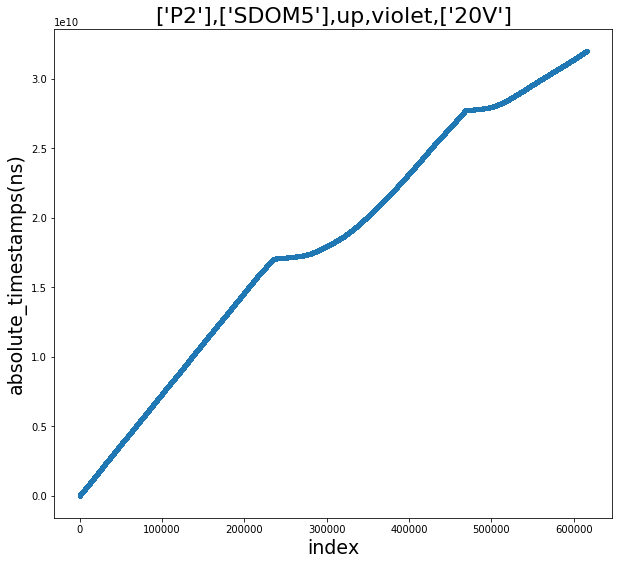

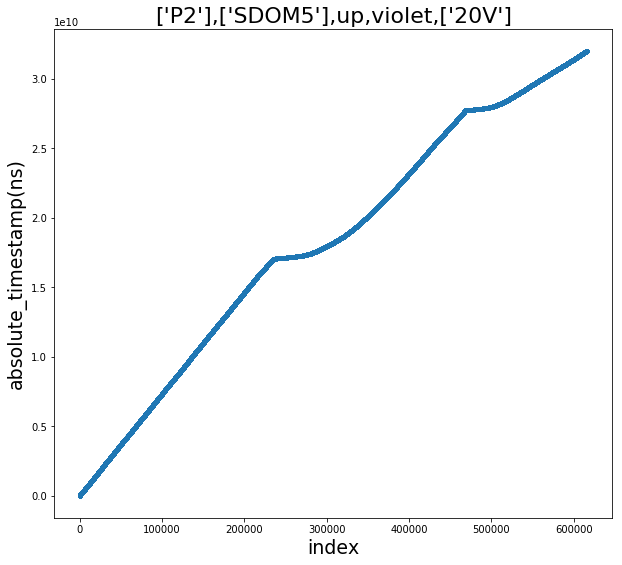

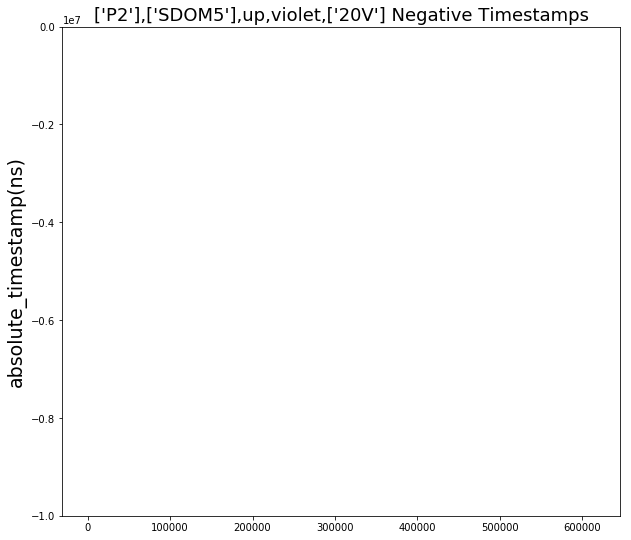

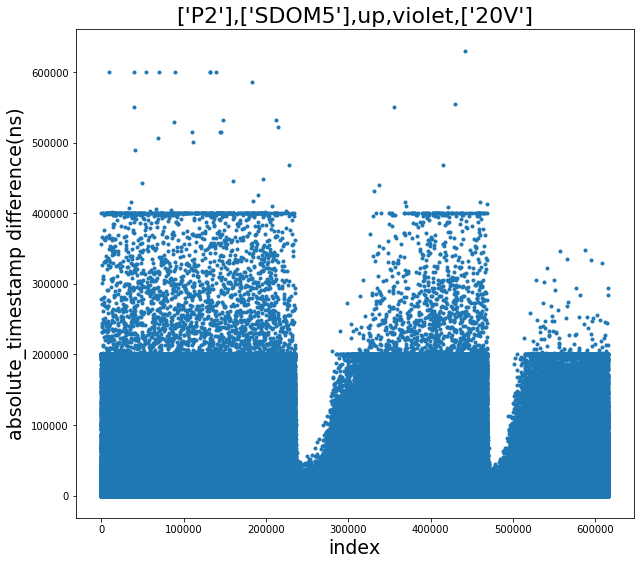

[]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:166: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:170: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:171: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:173: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the futur

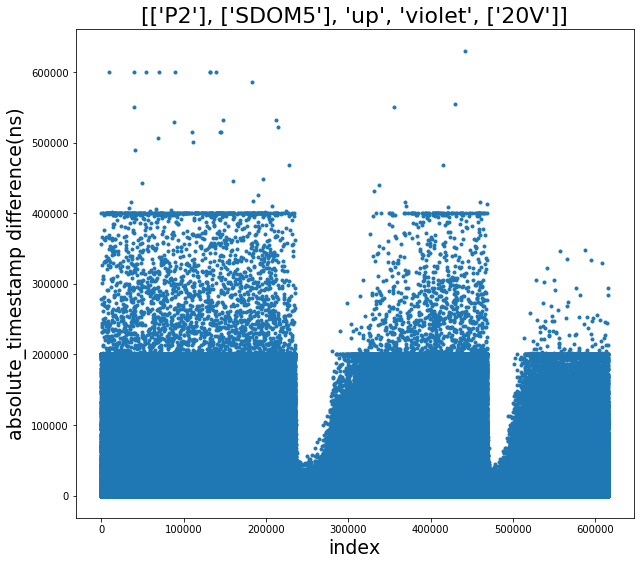

3.7653154382312417


In [9]:
(abs_elim_3, rising_0_elim_3, rising_1_elim_3, rising_2_elim_3, rising_3_elim_3,
 falling_0_elim_3, falling_1_elim_3, falling_2_elim_3, falling_3_elim_3, POCAM_num, values,
atstamp, p_jumps, dt_mean, f_r, values, file_path, SDOM_num, PMT) = a.P_S_used()

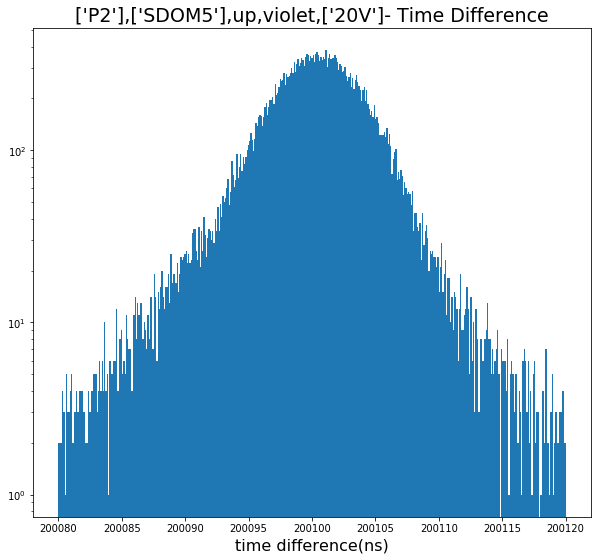

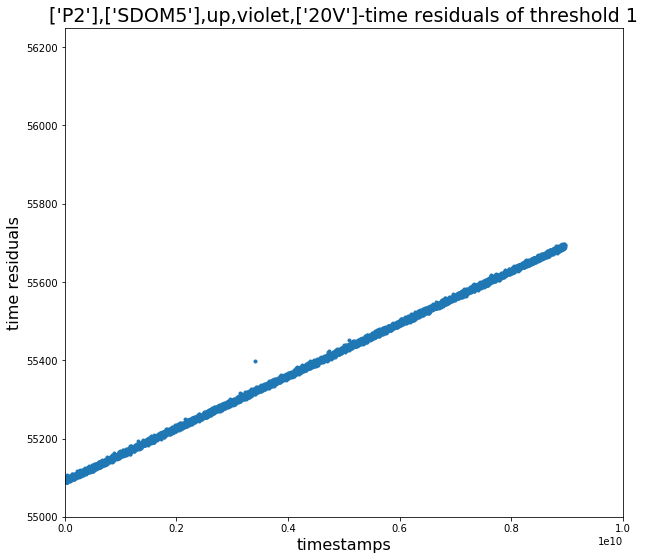

In [10]:
r1 = residual(rising_1_elim_3,200080, 200120, 400, 
                                200095, 200105,
             0.0e10,1.0e10,55000, 56250)

In [11]:
gaus_peak = r1.minimizer(0.0e10, 0.8e10)

200100.34341989143


25844
jump_index [    0.  2982.  2983.  7676. 10384. 11159. 12028. 12403. 13630. 14436.
 15001. 19421. 19936. 19937. 20852. 21725. 21726. 22395. 24678.]
jump_index size 19
index_p 0
Jump Indices 0 2983
2983


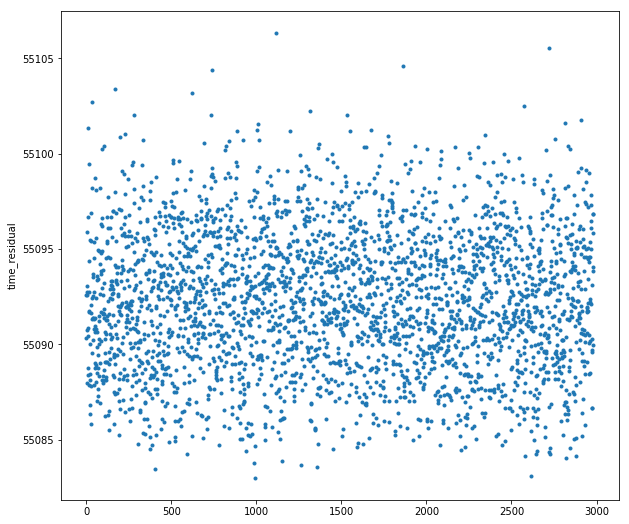

index_p 1
Jump Indices 2983 2984
1


/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:728: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


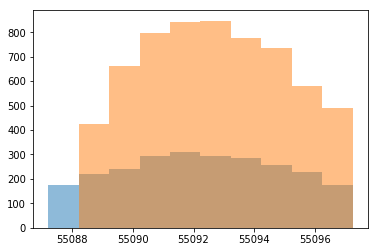

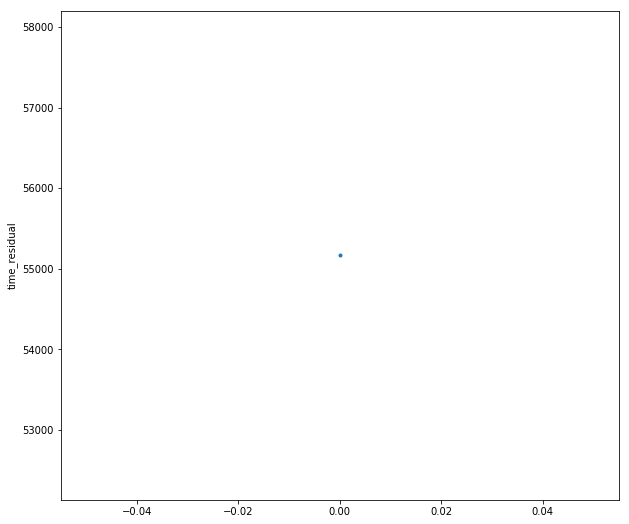

index_p 2
Jump Indices 2984 7677
4693


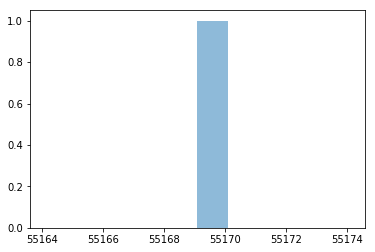

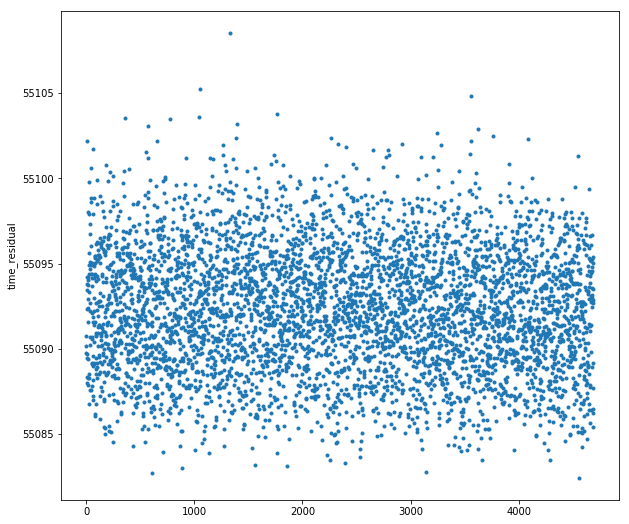

index_p 3
Jump Indices 7677 10385
2708


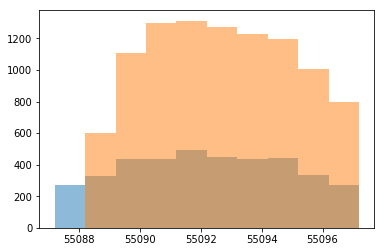

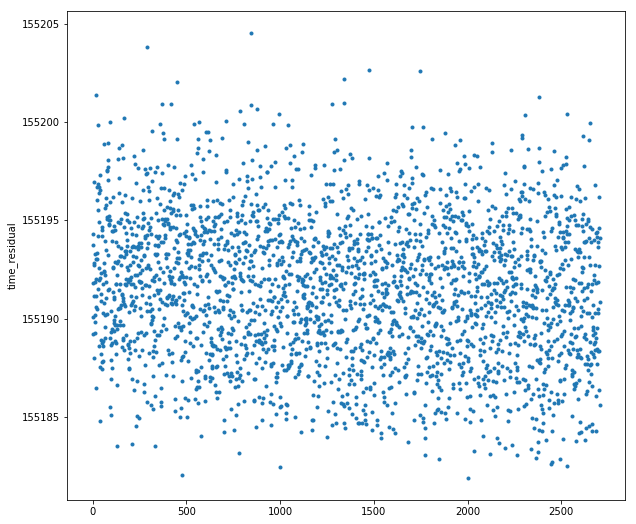

index_p 4
Jump Indices 10385 11160
775


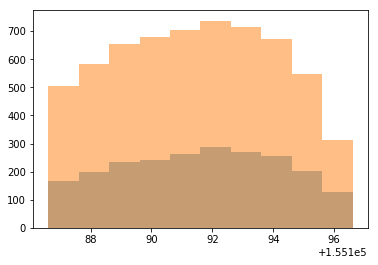

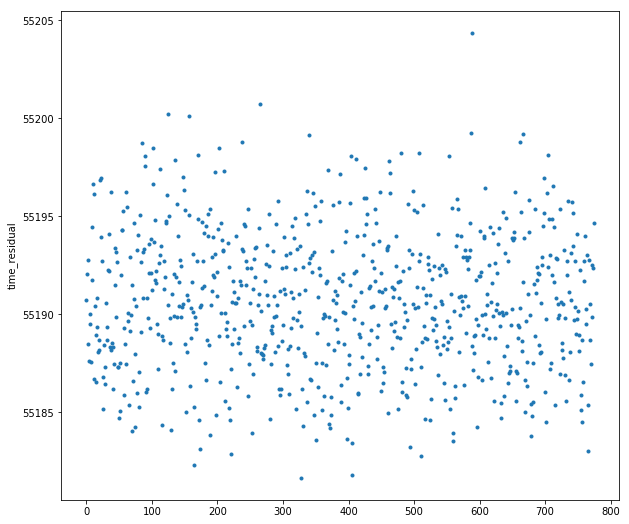

index_p 5
Jump Indices 11160 12029
869


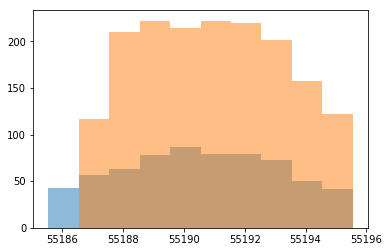

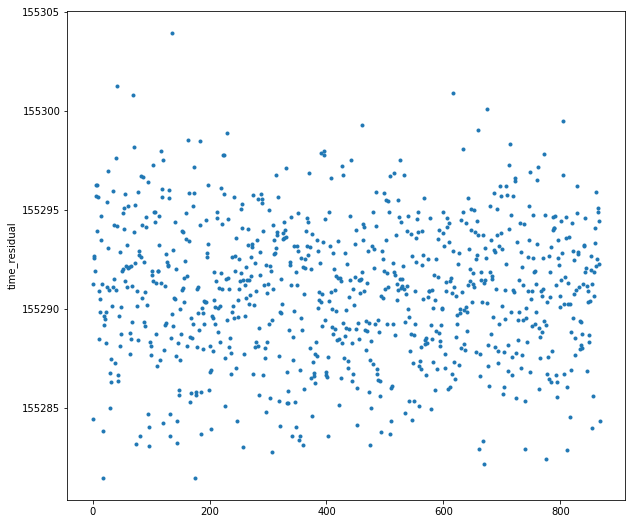

index_p 6
Jump Indices 12029 12404
375


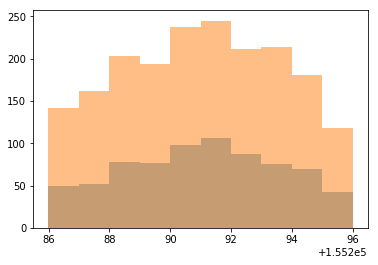

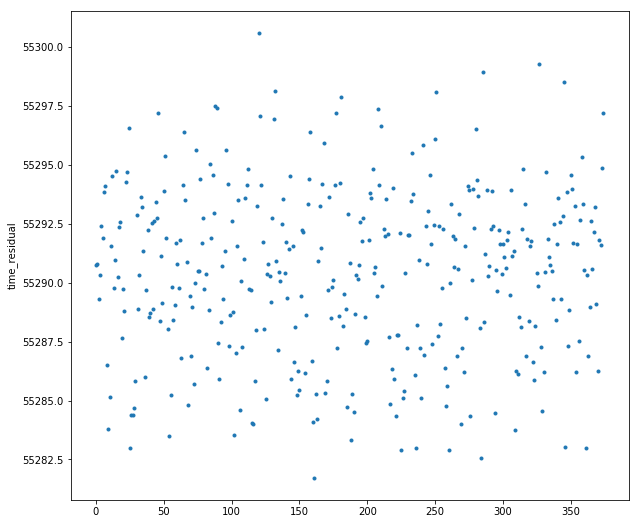

index_p 7
Jump Indices 12404 13631
1227


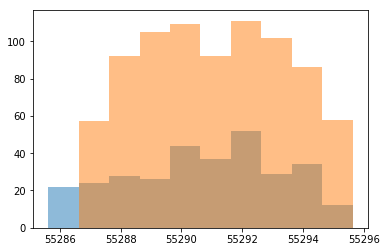

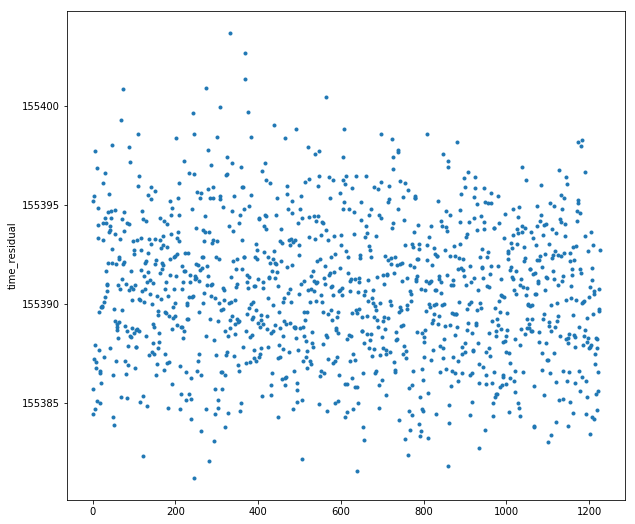

index_p 8
Jump Indices 13631 14437
806


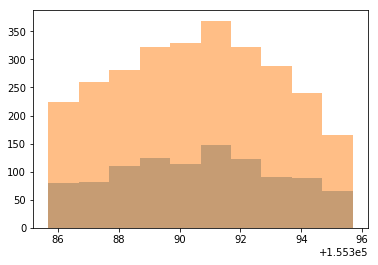

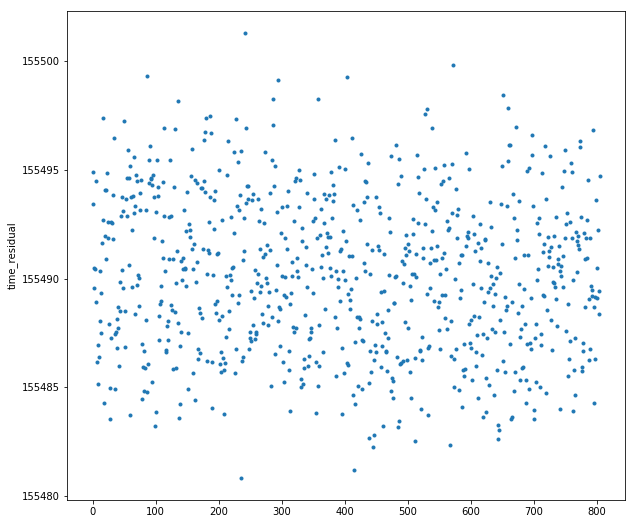

index_p 9
Jump Indices 14437 15002
565


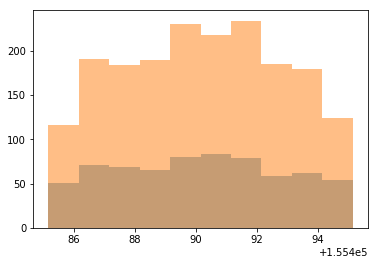

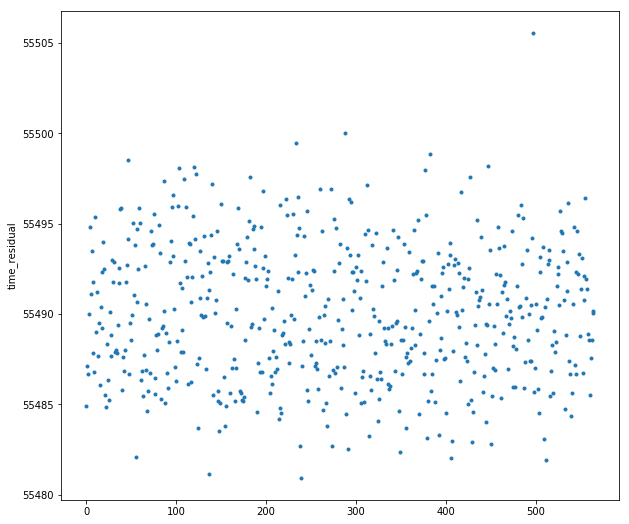

index_p 10
Jump Indices 15002 19422
4420


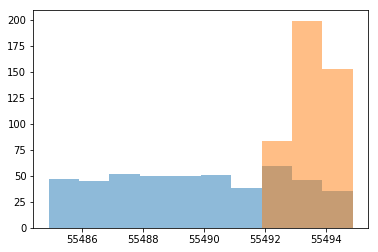

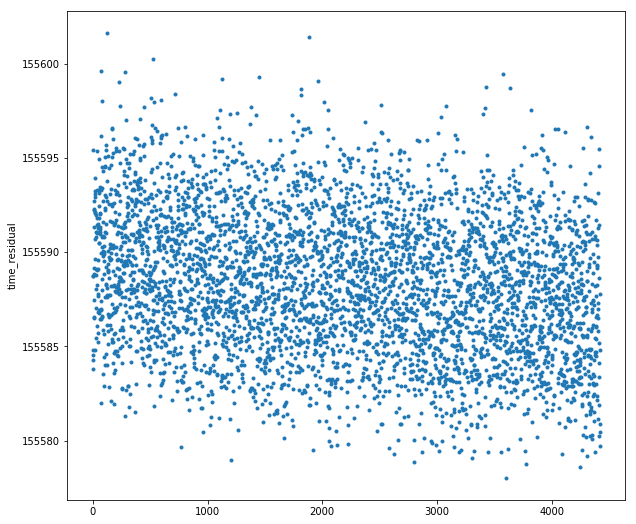

index_p 11
Jump Indices 19422 19937
515


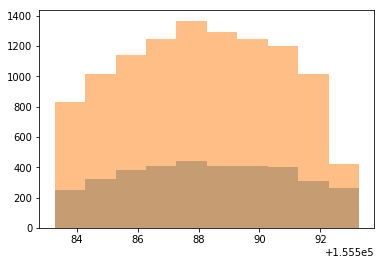

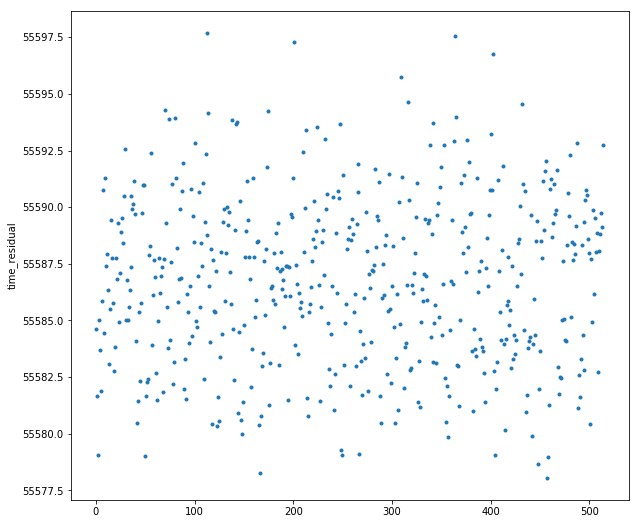

index_p 12
Jump Indices 19937 19938
1


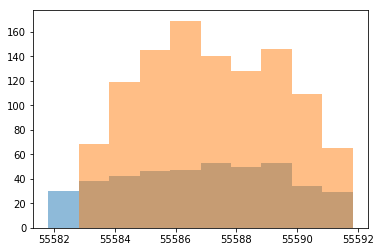

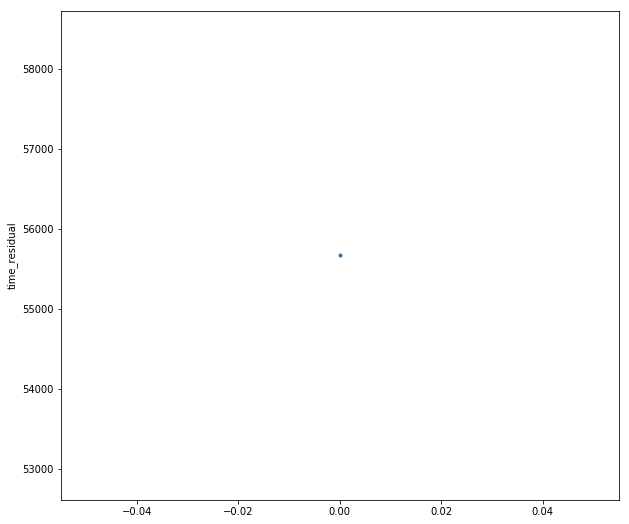

index_p 13
Jump Indices 19938 20853
915


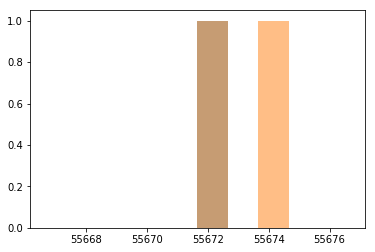

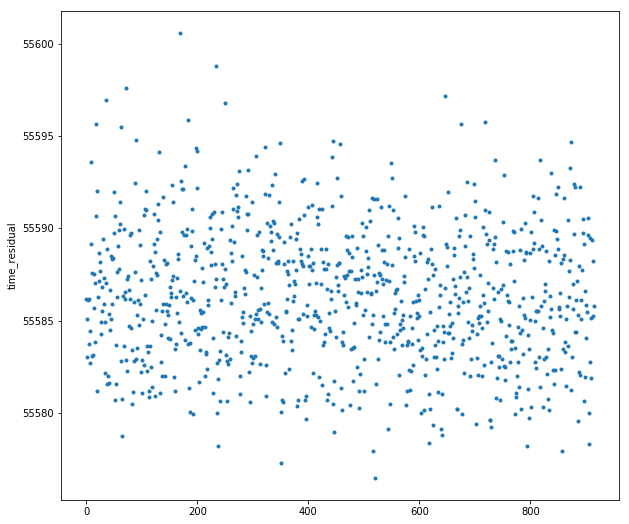

index_p 14
Jump Indices 20853 21726
873


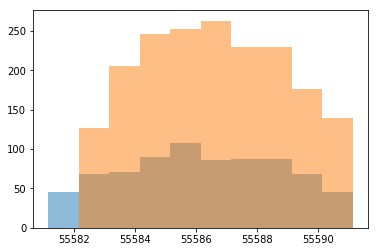

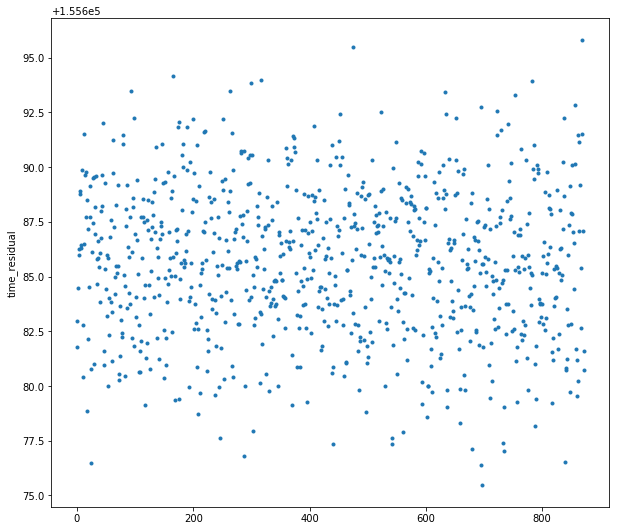

index_p 15
Jump Indices 21726 21727
1


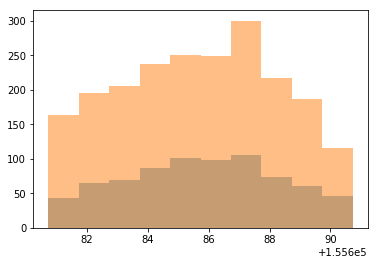

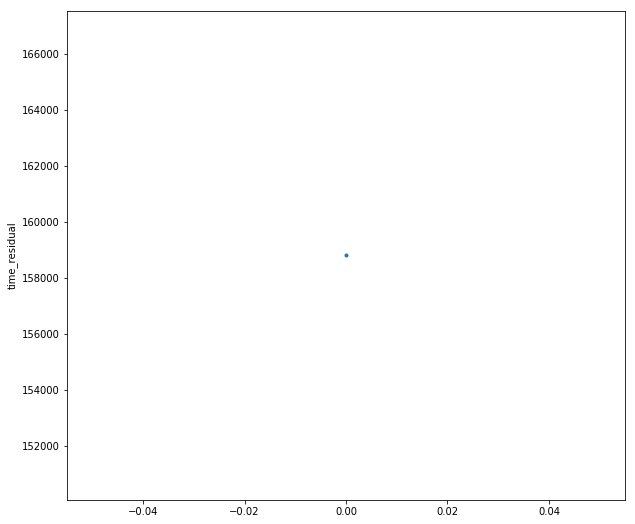

index_p 16
Jump Indices 21727 22396
669


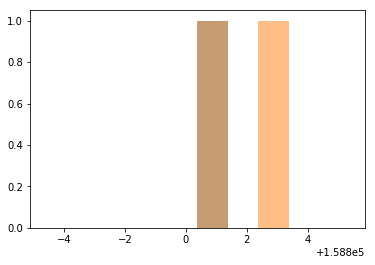

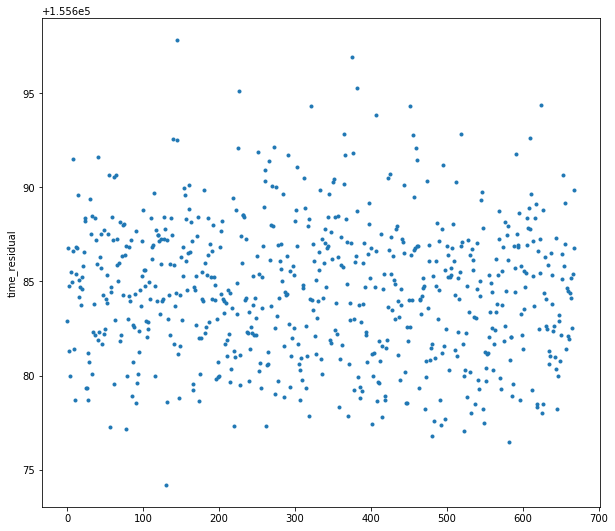

index_p 17
Jump Indices 22396 24679
2283


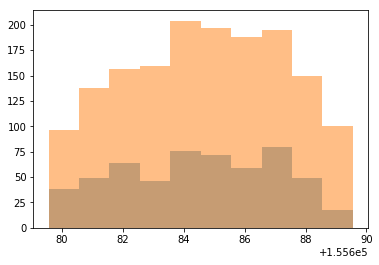

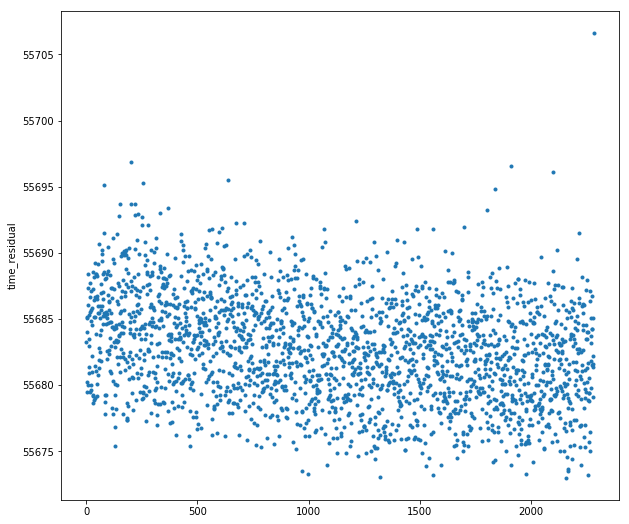

index_p 18
Jump Index size = 19 25843
[24679]
Jump Indices 24679 25843


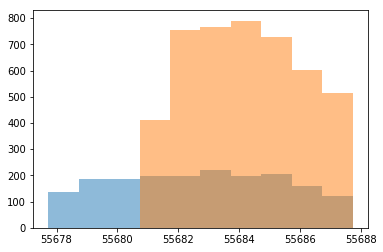

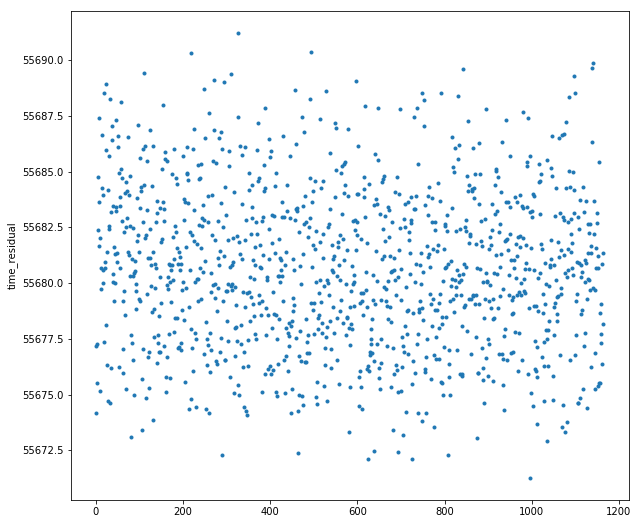

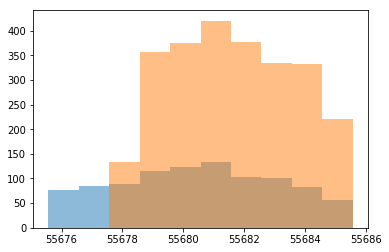

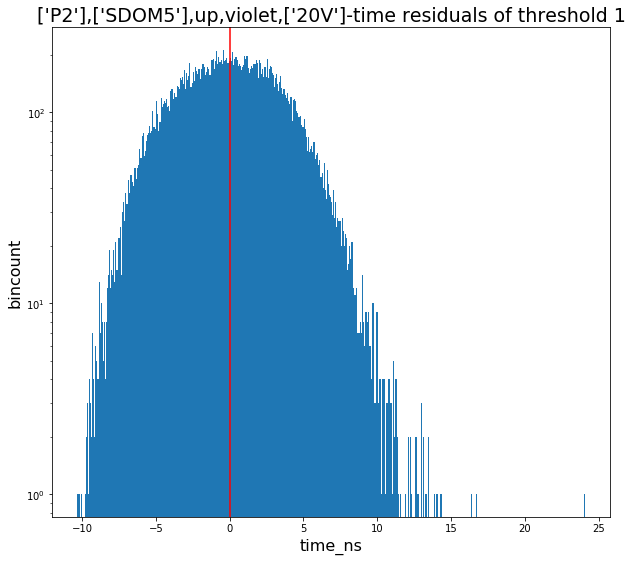

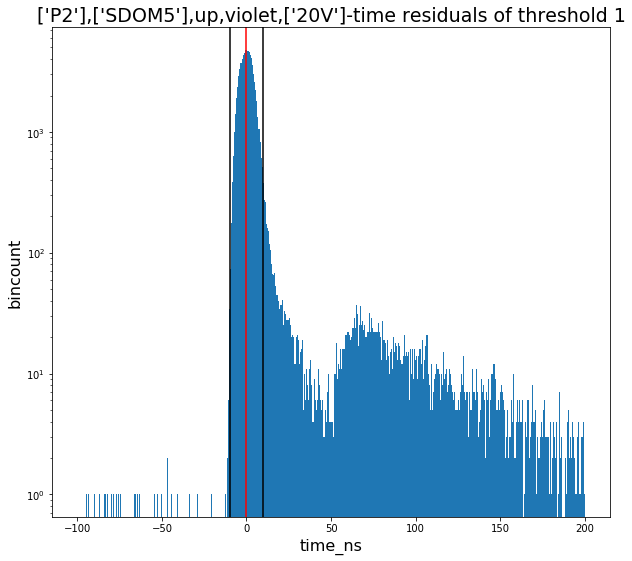

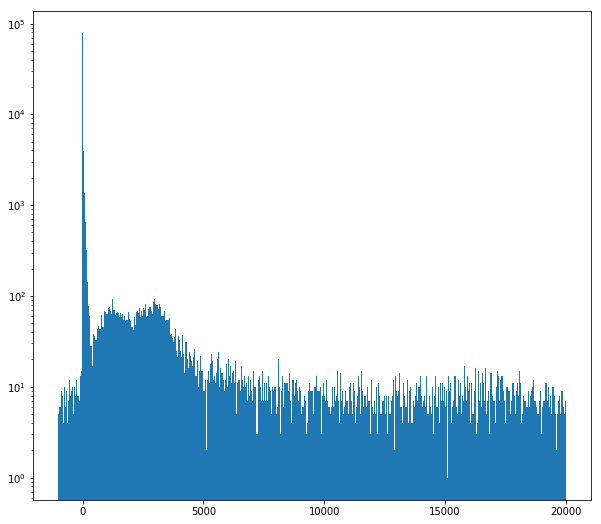

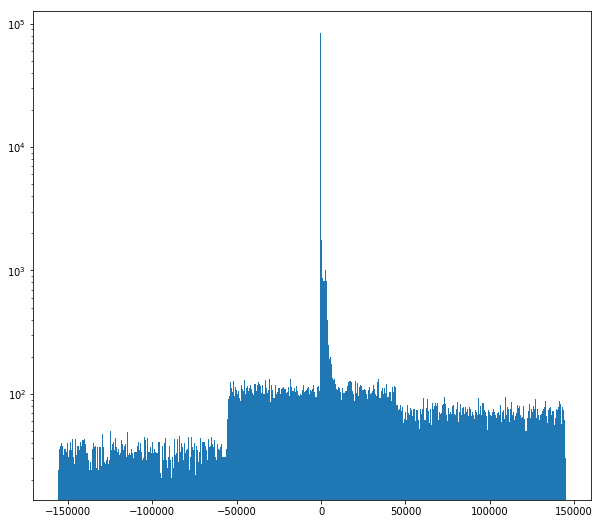

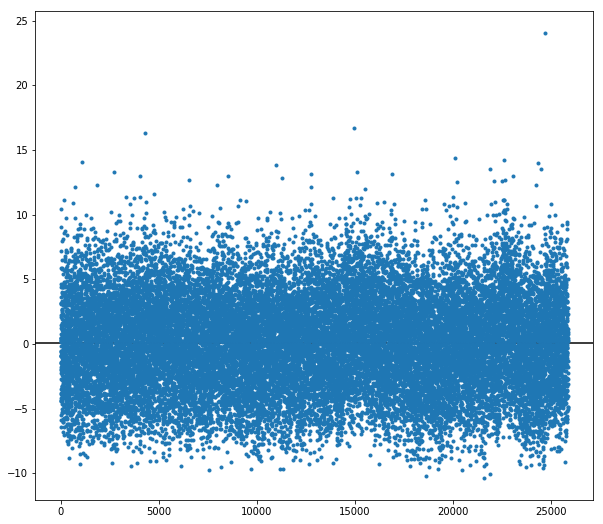

In [12]:
 num_events1, est_res_diff, t_res_all1, what_peak, noise_events1 = r1.res(30, 5)

In [13]:
RunTime1, error_rtime1 = run_time(atstamp, p_jumps)

timestamp of the last event -  32016329531.257812
eliminating high jumps and summing -  32007938366.92969
run time -  32007938366.92969


In [14]:
distance1, angle_cr1 = angl_dist()

In [15]:
eve_p_sec1, error_nevents1 = correction(num_events1, angle_cr1, RunTime1)

In [16]:
eve_p_sec1

2520.518832051501

In [17]:
b = clean('20181205_092552_UTC_SDOM1_FLASH_SANTACLAUS_P2_violet_both_5000Hz_20V_60s_18339135919.hld_up.hdf5')

percentage of high jumps in the file - 0.4130134600662307


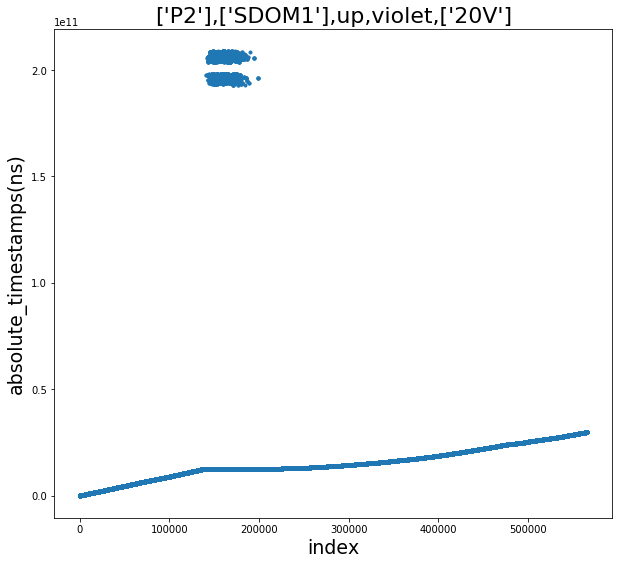

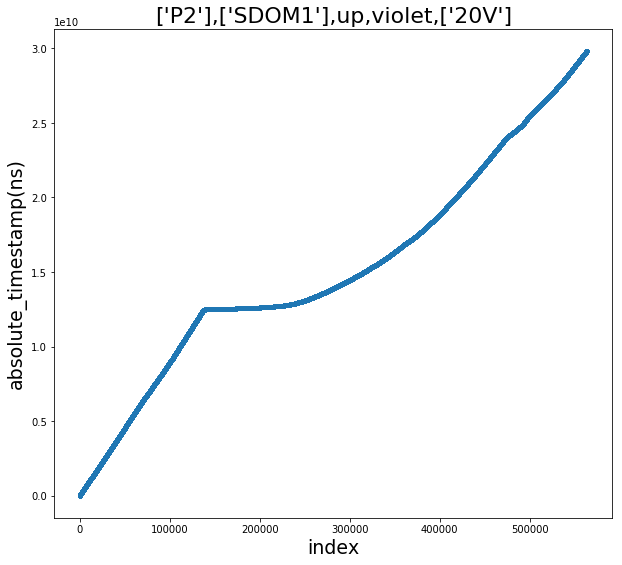

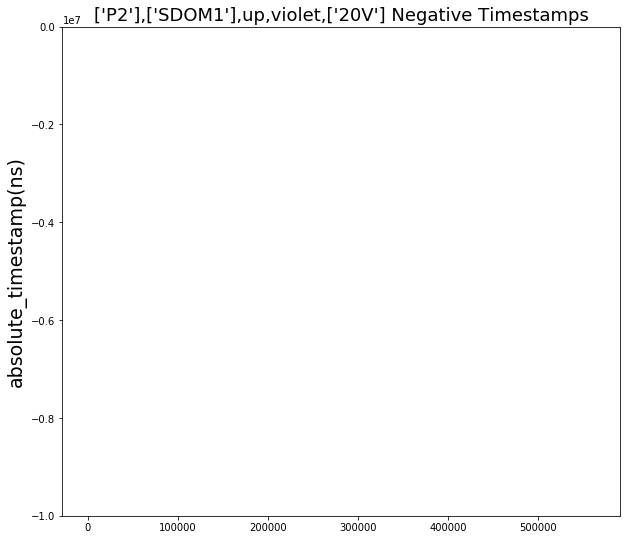

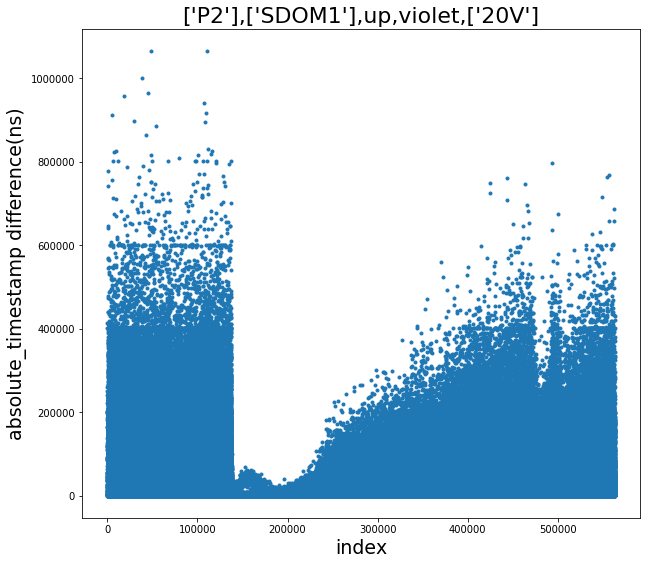

[]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:166: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:170: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:171: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:173: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the futur

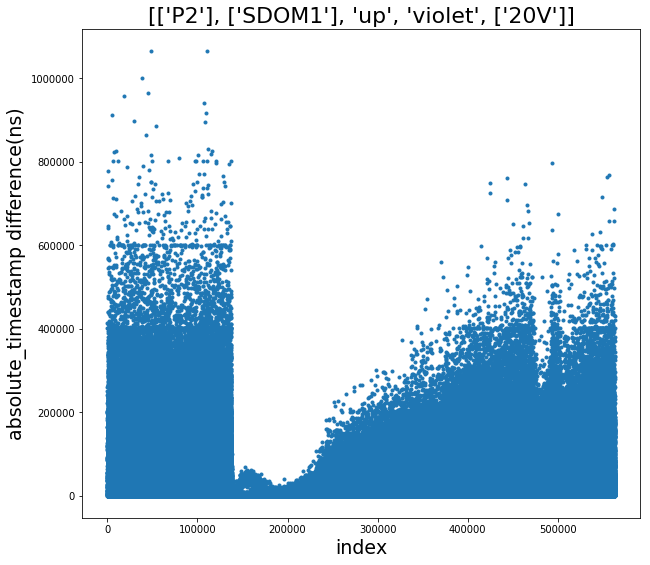

0.8508337346981528


In [18]:
(abs_elim_3, rising_0_elim_3, rising_1_elim_3, rising_2_elim_3, rising_3_elim_3,
falling_0_elim_3, falling_1_elim_3, falling_2_elim_3, falling_3_elim_3, POCAM_num, values,
atstamp, p_jumps, dt_mean, f_r, values, file_path, SDOM_num, PMT) = b.P_S_used()

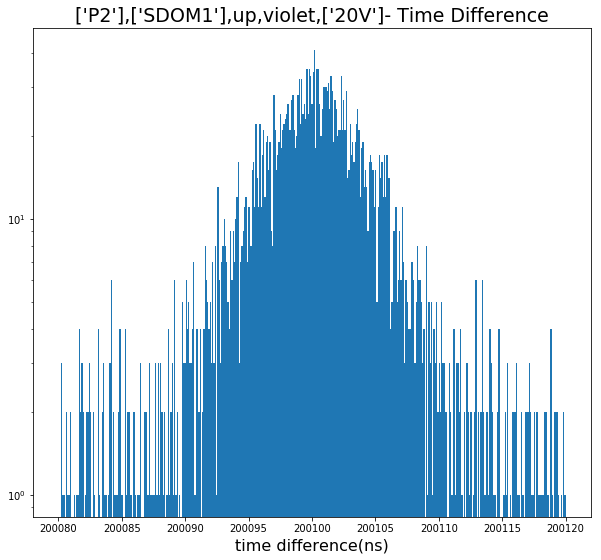

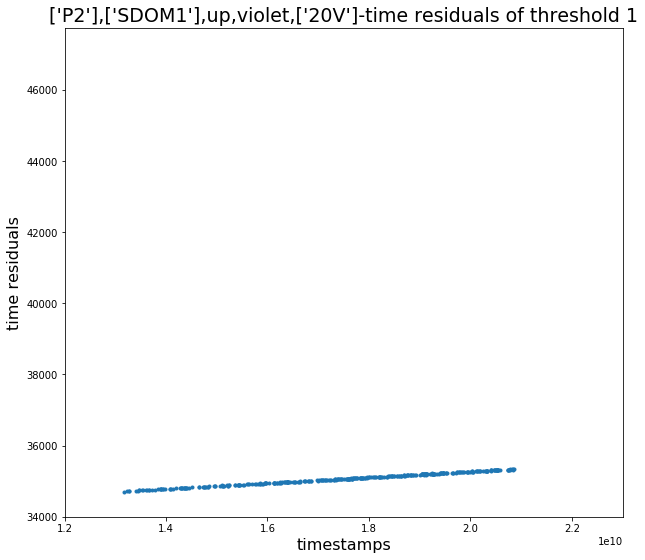

In [19]:
r2 = residual(rising_1_elim_3,200080, 200120, 400, 
                                200095, 200105,
             1.20e10,2.3e10,34000, 47750)

In [20]:
gaus_peak = r2.minimizer(1.8e10, 2.0e10)

200100.34604355978


2141
jump_index [   0.   20.   71.  530.  647.  648.  896.  897. 1082. 1083. 1103. 1374.
 1375. 1465. 1721. 1802. 1846. 2116. 2117.]
jump_index size 19
index_p 0
Jump Indices 0 21
21


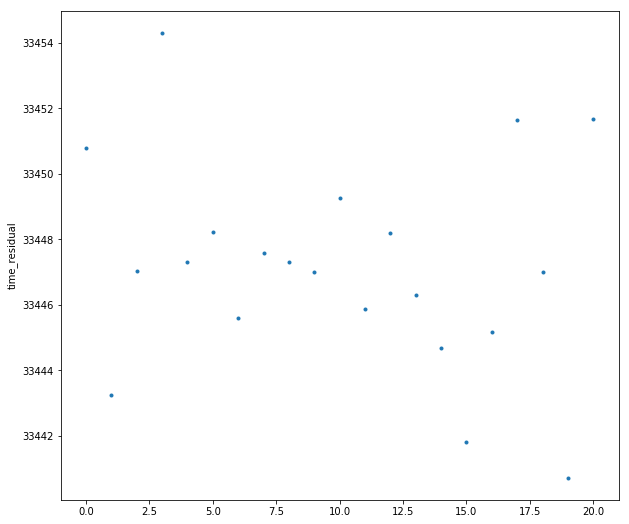

index_p 1
Jump Indices 21 72
51


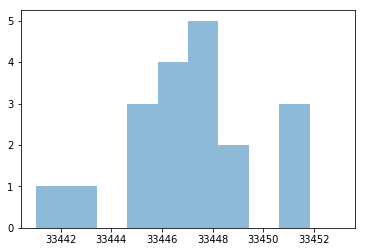

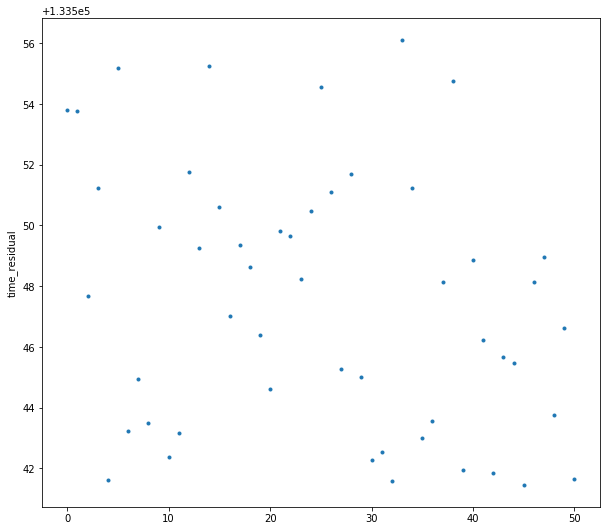

index_p 2
Jump Indices 72 531
459


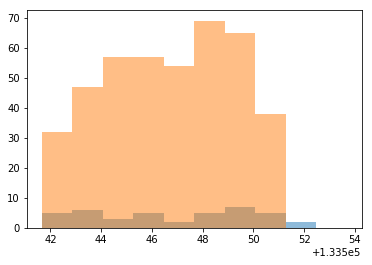

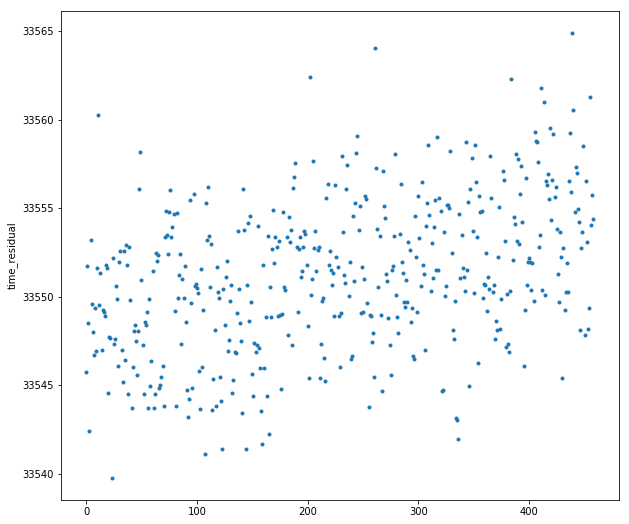

index_p 3
Jump Indices 531 648
117


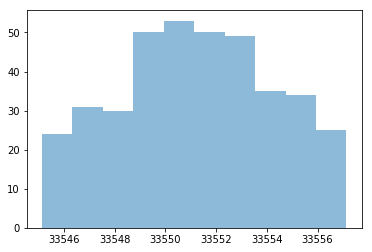

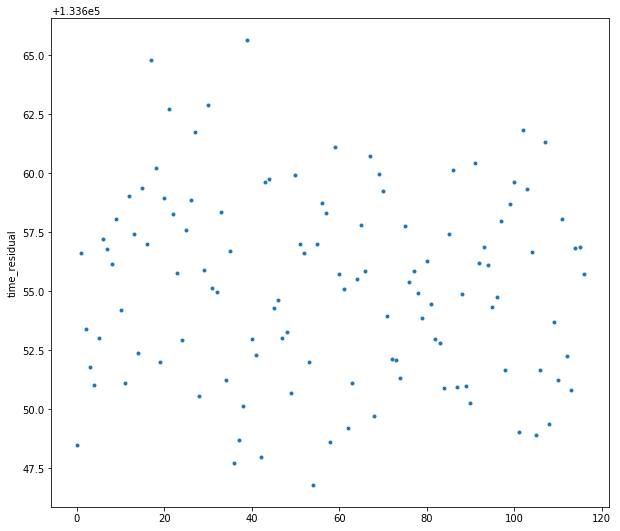

index_p 4
Jump Indices 648 649
1


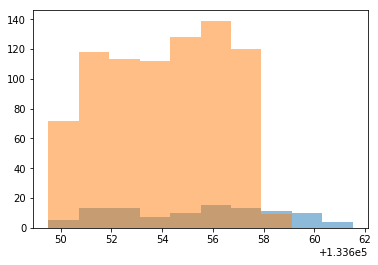

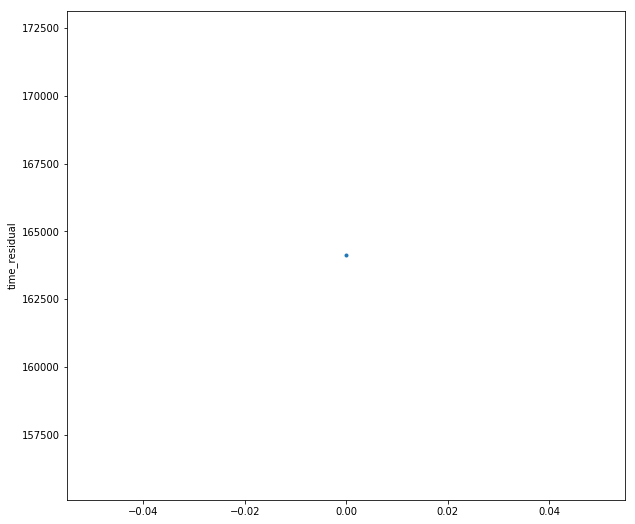

index_p 5
Jump Indices 649 897
248


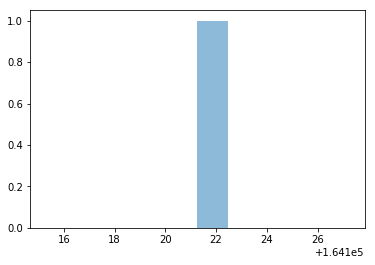

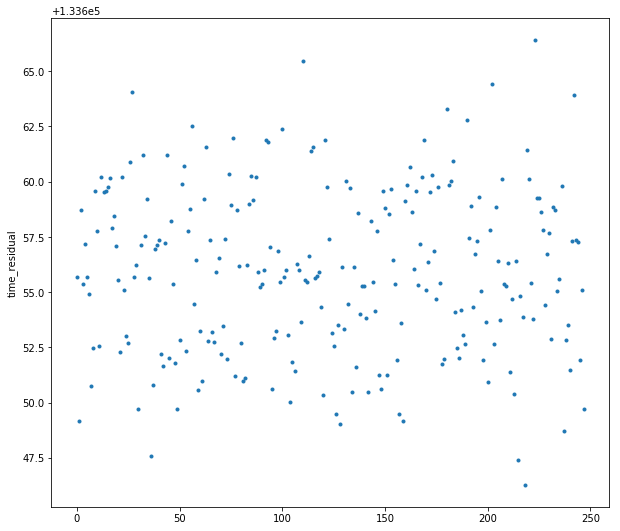

index_p 6
Jump Indices 897 898
1


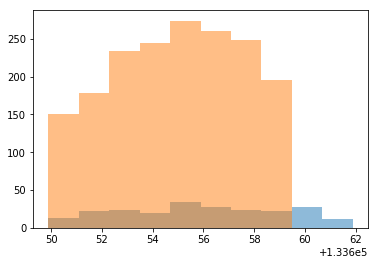

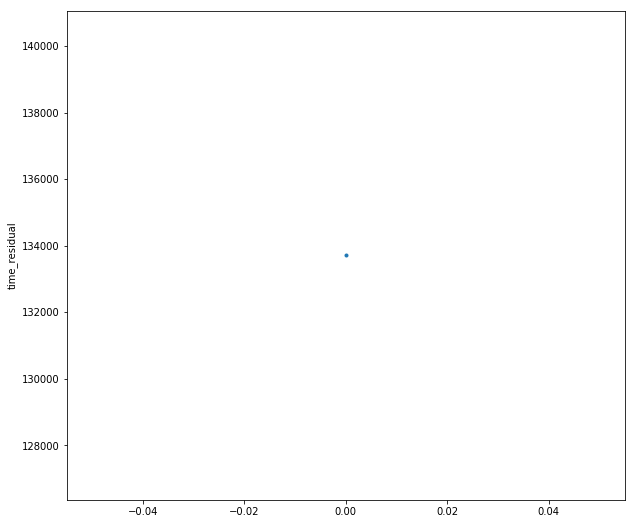

index_p 7
Jump Indices 898 1083
185


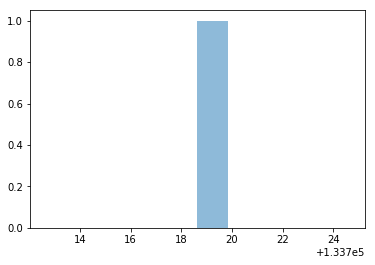

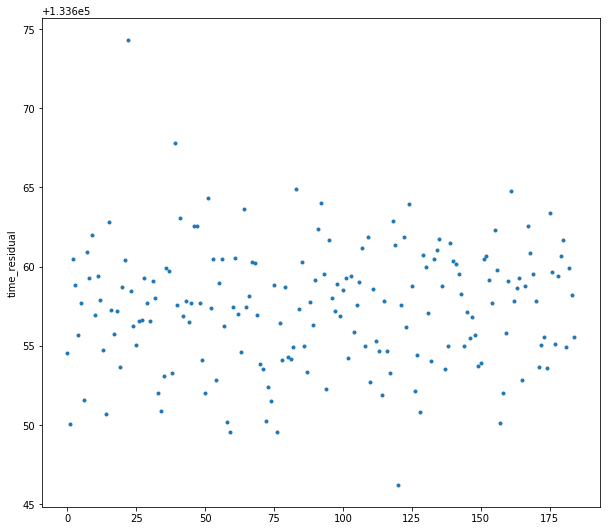

index_p 8
Jump Indices 1083 1084
1


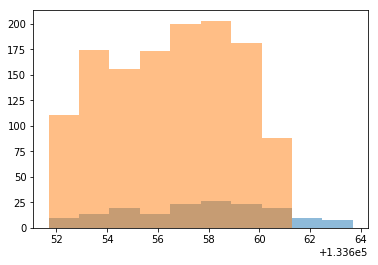

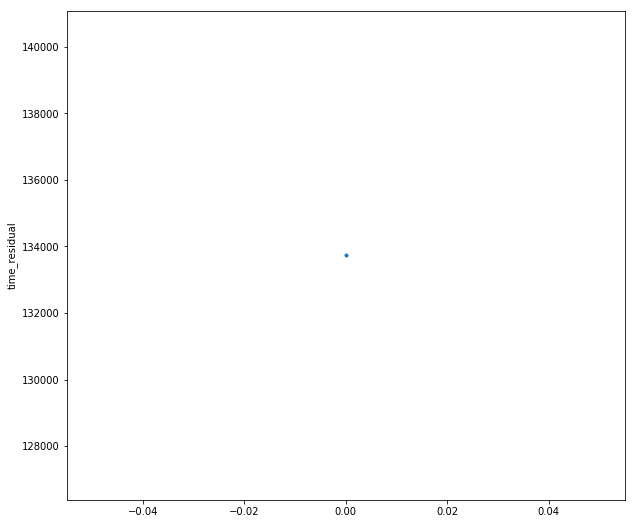

index_p 9
Jump Indices 1084 1104
20


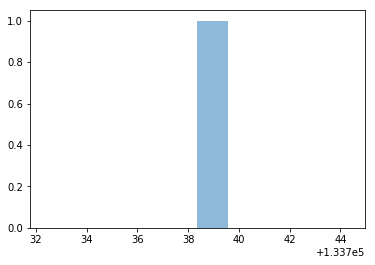

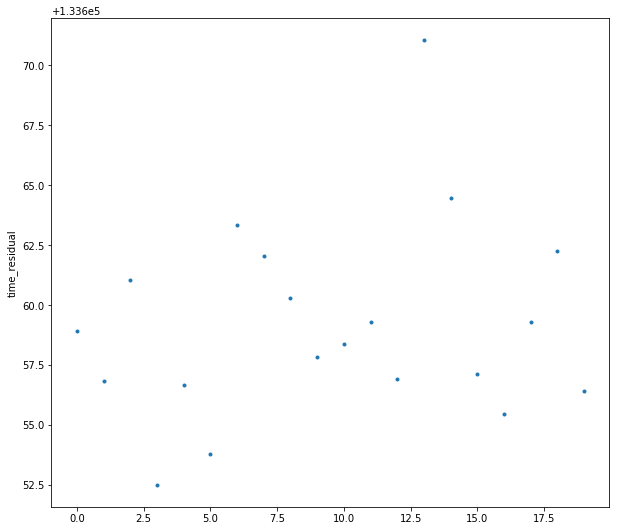

index_p 10
Jump Indices 1104 1375
271


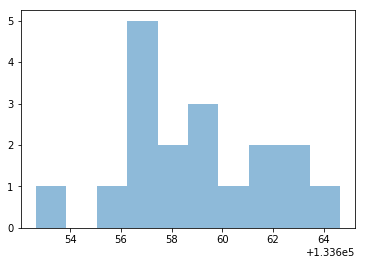

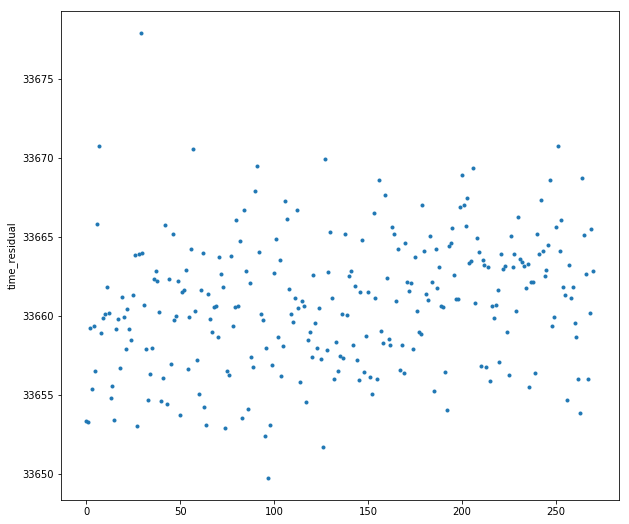

index_p 11
Jump Indices 1375 1376
1


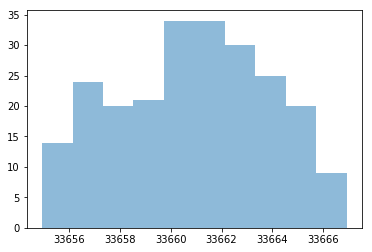

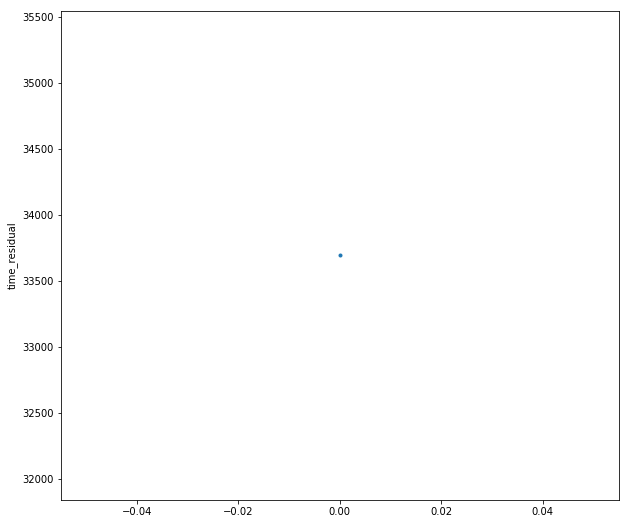

index_p 12
Jump Indices 1376 1466
90


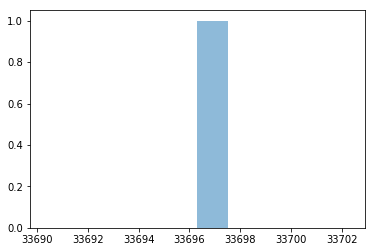

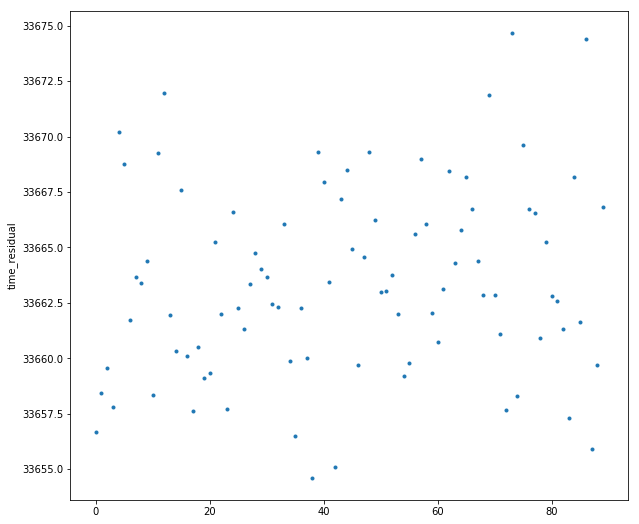

index_p 13
Jump Indices 1466 1722
256


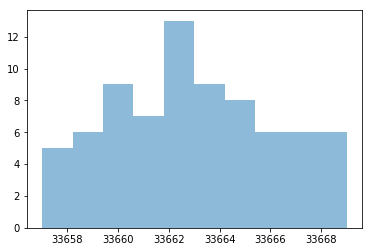

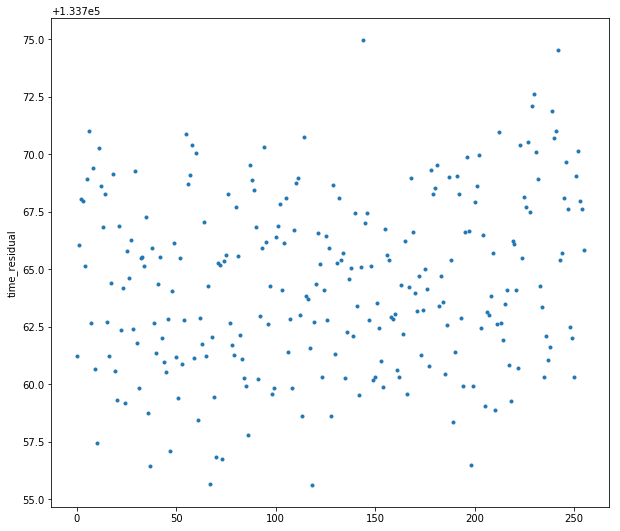

index_p 14
Jump Indices 1722 1803
81


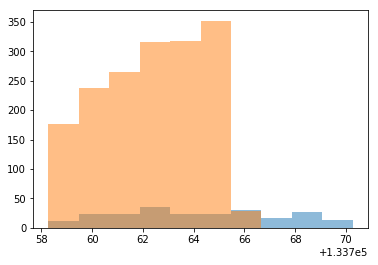

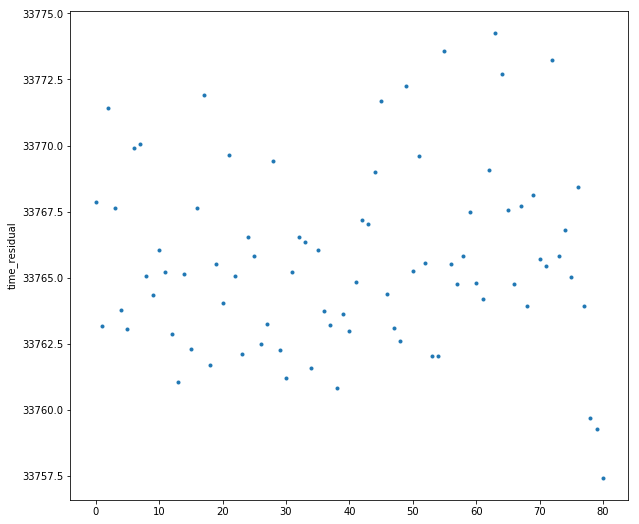

index_p 15
Jump Indices 1803 1847
44


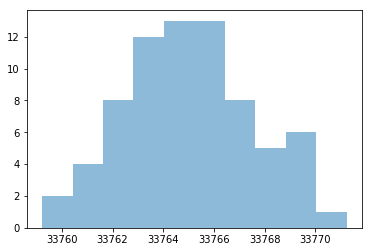

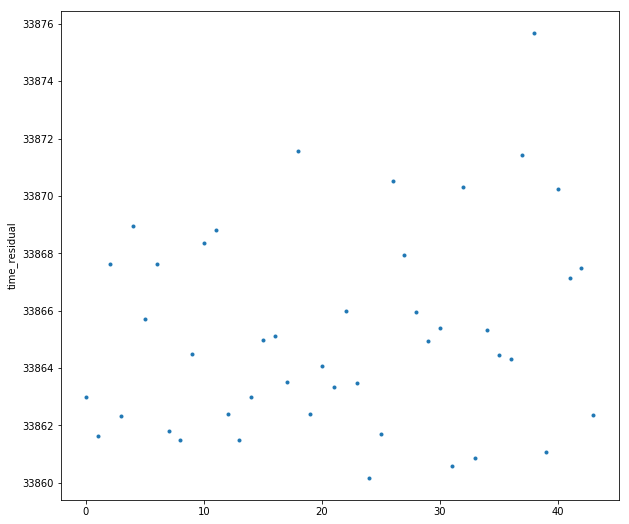

index_p 16
Jump Indices 1847 2117
270


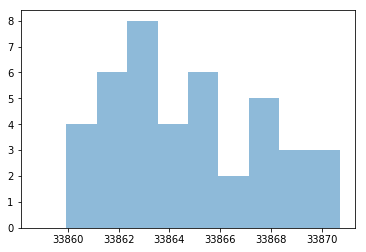

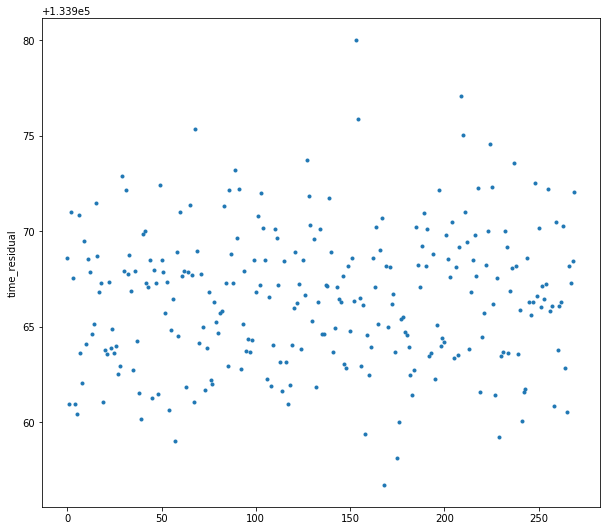

index_p 17
Jump Indices 2117 2118
1


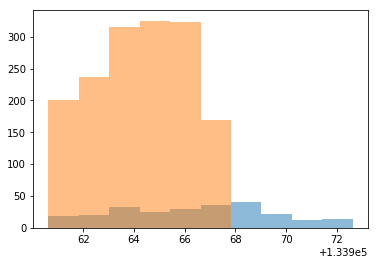

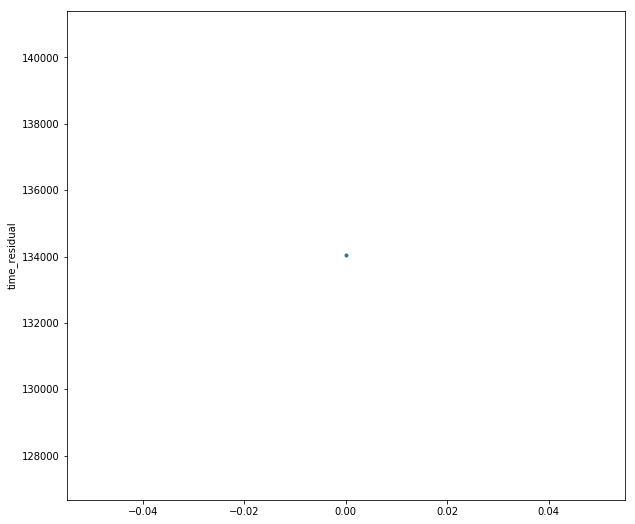

index_p 18
Jump Index size = 19 2140
[2118]
Jump Indices 2118 2140


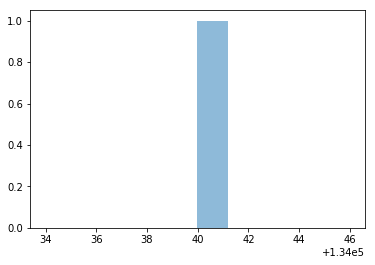

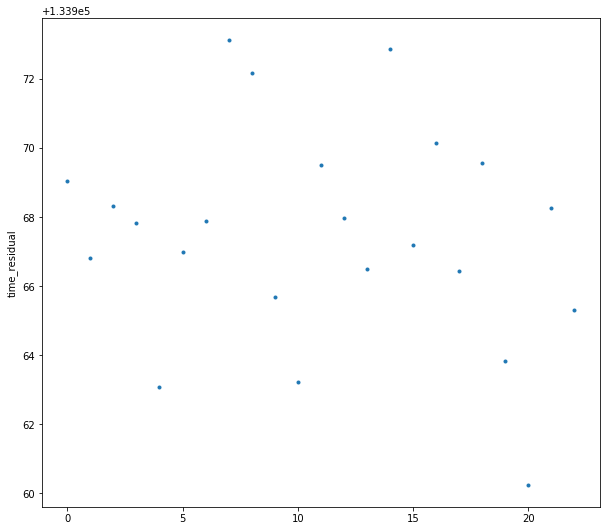

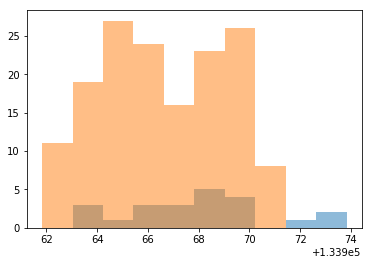

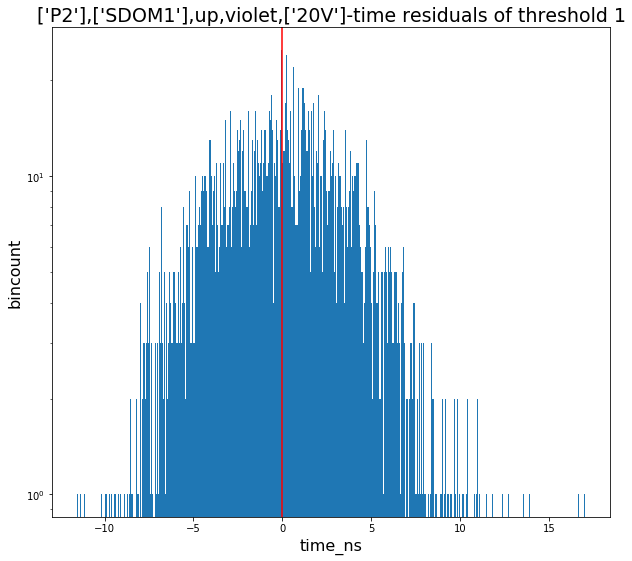

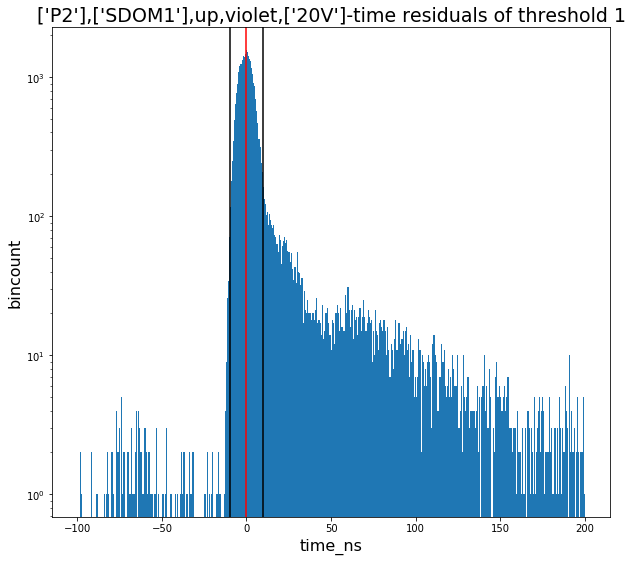

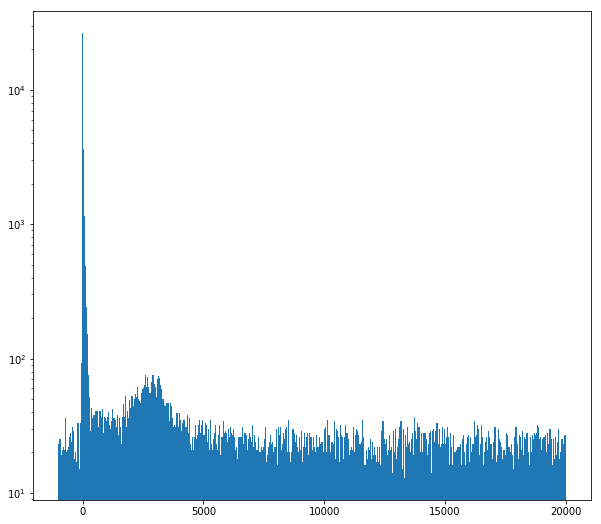

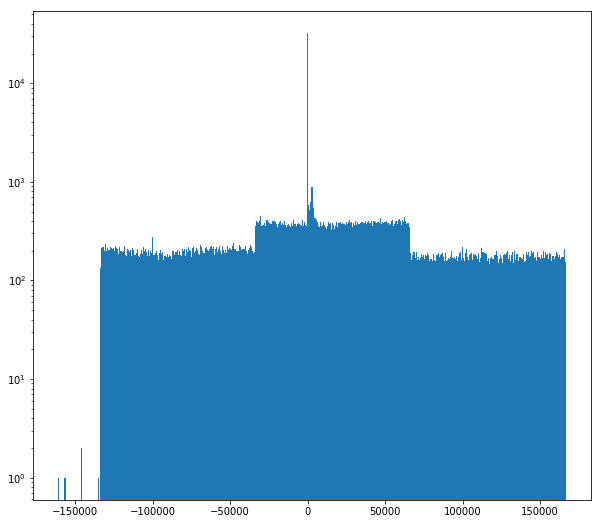

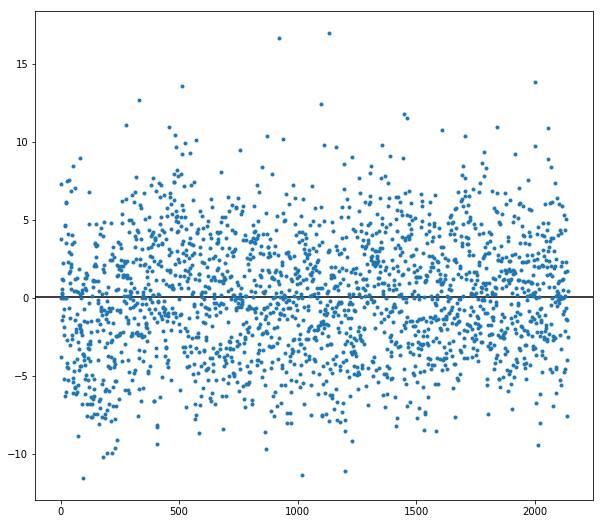

In [21]:
 num_events2, est_res_diff, t_res_all1, what_peak, noise_events2 = r2.res(30, 6)

In [22]:
RunTime2, error_rtime2 = run_time(atstamp, p_jumps)

141270

142632 141273
142688 142635
142836 142690
143034 142844
143145 143043
143306 143152
143361 143314
143515 143367
143667 143520
143778 143672
143981 143780
144190 143984
144246 144194
144464 144249
144568 144468
144738 144576
144847 144743
144903 144850
144959 144907
145015 144964
145069 145021
145125 145071
145181 145129
145238 145187
145294 145245
145351 145296
145518 145355
145573 145525
145629 145576
145685 145632
145850 145696
145906 145854
145963 145910
146020 145966
146187 146024
146243 146189
146298 146245
146353 146301
146462 146360
146520 146472
146576 146522
146689 146583
146800 146693
146856 146808
146912 146863
146968 146921
147024 146972
147079 147026
147191 147090
147247 147195
147303 147255
147360 147315
147417 147365
147474 147419
147531 147476
147585 147537
147642 147588
147866 147648
147976 147869
148032 147986
148088 148034
148145 148090
148202 148153
148258 148207
148314 148268
148371 148317
148541 148374
148597 148548
148652 148601
148764 148658
148873 14876

timestamp of the last event -  29837096565.778812
eliminating high jumps and summing -  29809956923.73974
run time -  29809956923.73974


In [23]:
distance2, angle_cr2 = angl_dist()

In [24]:
eve_p_sec2, error_nevents2 = correction(num_events2, angle_cr2, RunTime2)

In [25]:
eve_p_sec2

921.0771540122689

In [26]:
c = clean('20181205_092552_UTC_SDOM2_FLASH_SANTACLAUS_P2_violet_both_5000Hz_20V_60s_18339135919.hld_up.hdf5')

percentage of high jumps in the file - 0.0


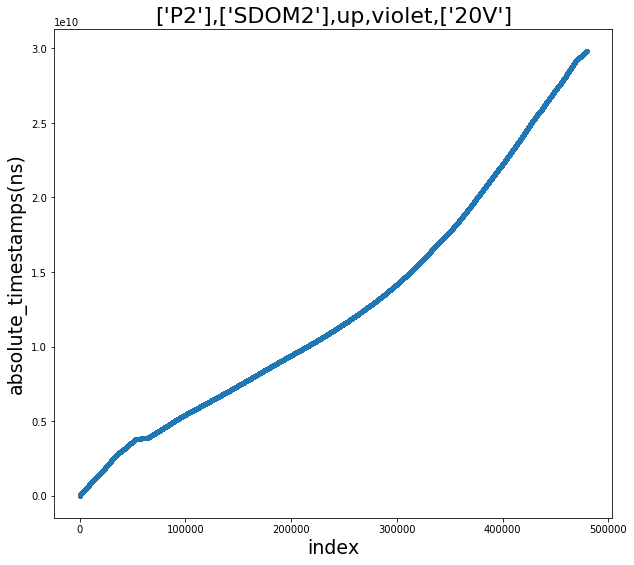

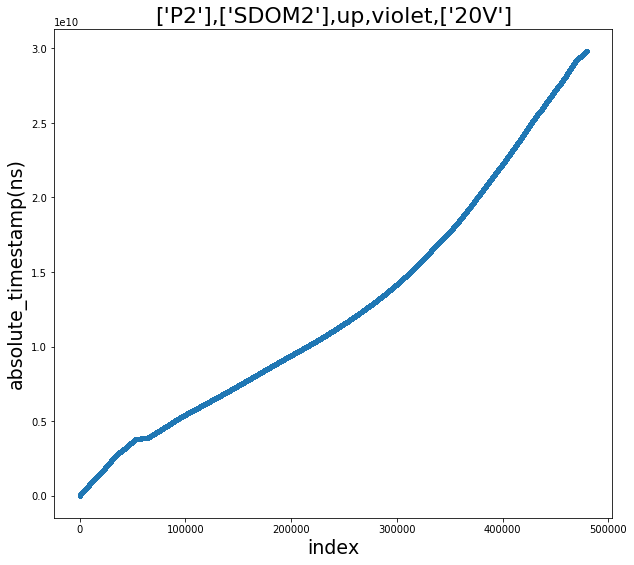

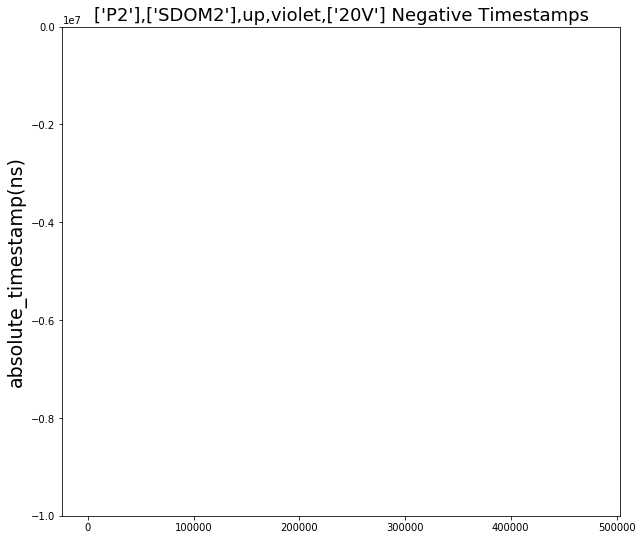

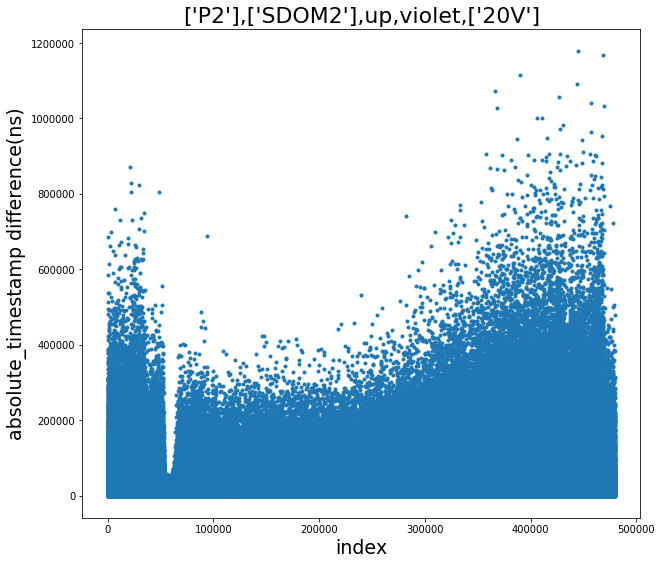

[]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:166: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:170: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:171: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:173: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the futur

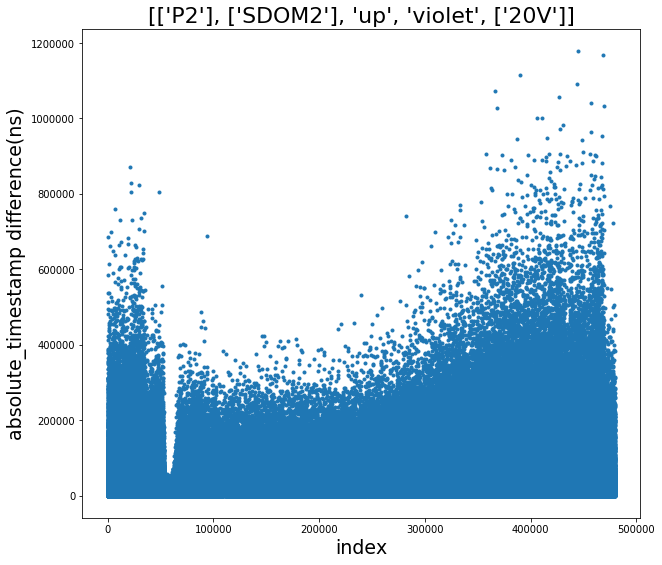

0.6322727625536771


In [27]:
(abs_elim_3, rising_0_elim_3, rising_1_elim_3, rising_2_elim_3, rising_3_elim_3,
falling_0_elim_3, falling_1_elim_3, falling_2_elim_3, falling_3_elim_3, POCAM_num, values,
atstamp, p_jumps, dt_mean, f_r, values, file_path, SDOM_num, PMT) = c.P_S_used()

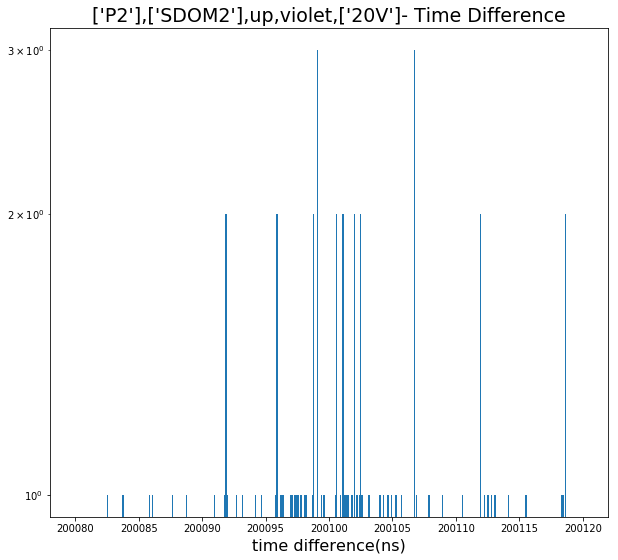

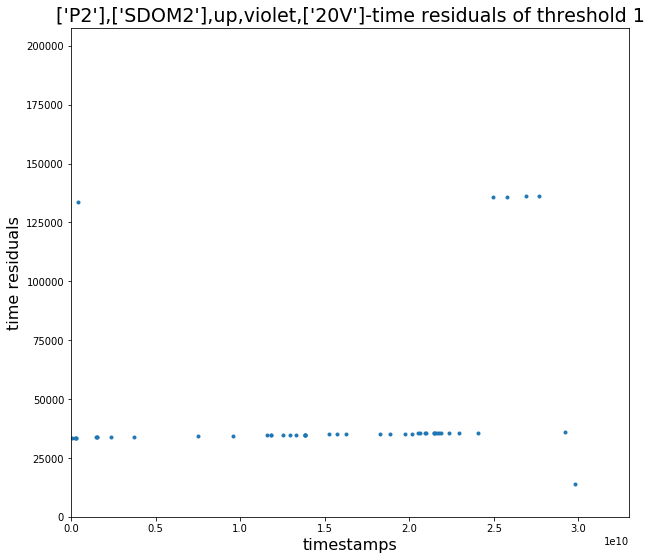

In [28]:
r3 = residual(rising_1_elim_3,200080, 200120, 400, 
                                200095, 200105,
             0.0e10,3.3e10,0, 207750)

48
jump_index [ 0.  3.  4.  7.  8.  9. 10. 11. 12. 14. 15. 17. 21. 22. 23. 24. 25. 26.
 27. 28. 32. 38. 40. 41. 42. 43. 44. 45. 46.]
jump_index size 29
index_p 0
Jump Indices 0 4
4


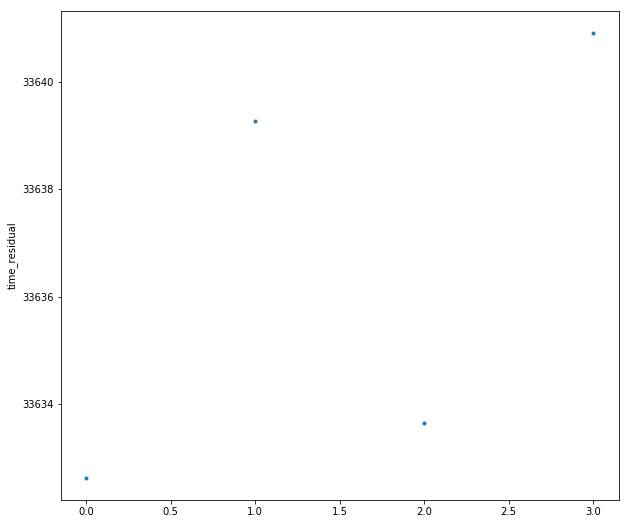

index_p 1
Jump Indices 4 5
1


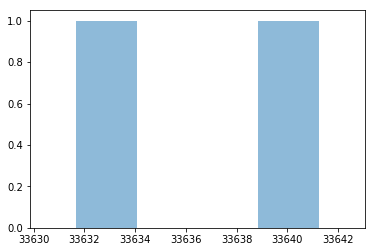

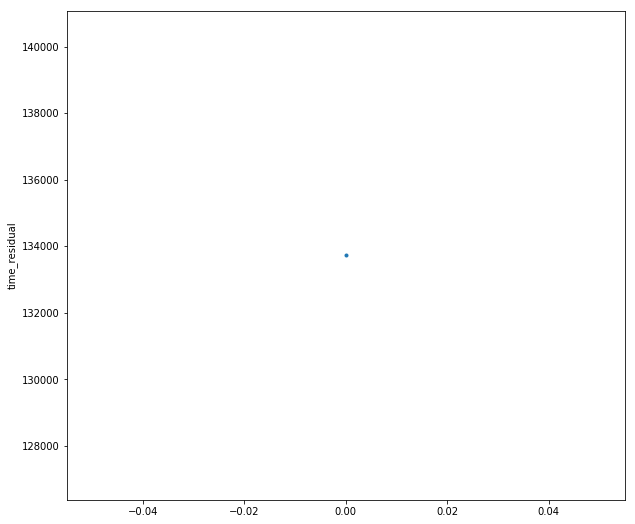

index_p 2
Jump Indices 5 8
3


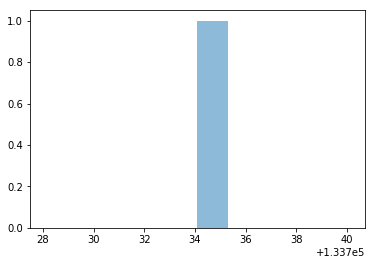

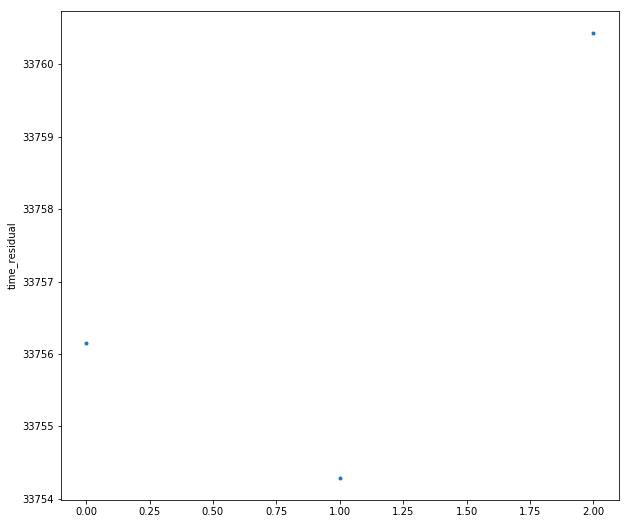

index_p 3
Jump Indices 8 9
1


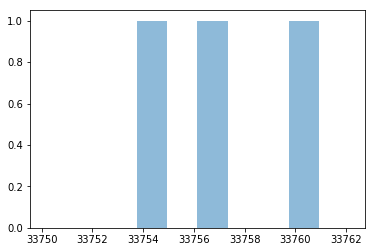

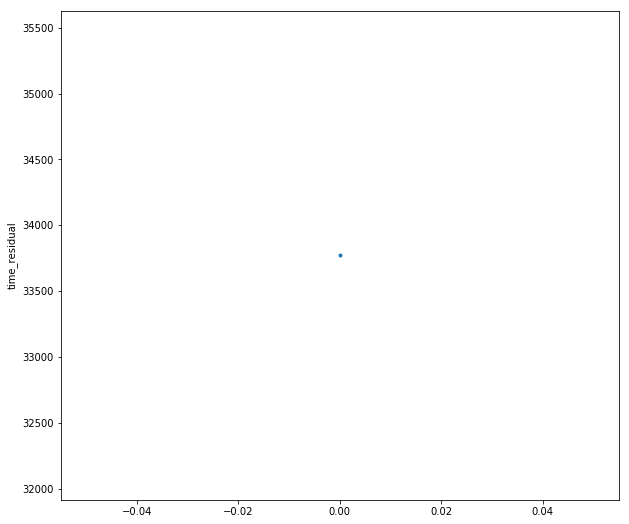

index_p 4
Jump Indices 9 10
1


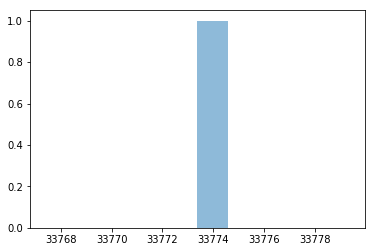

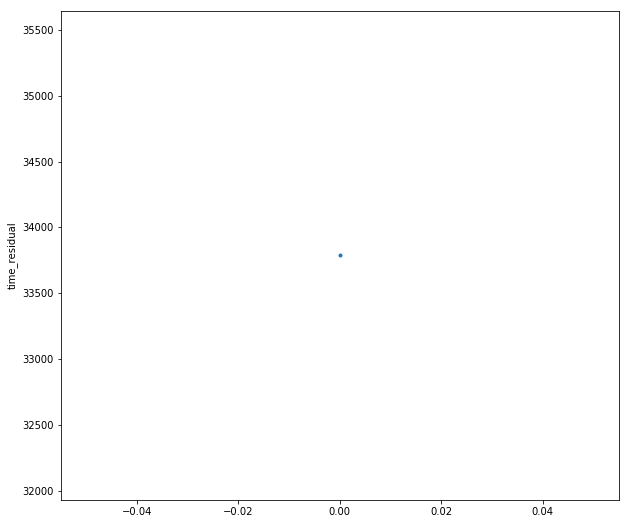

index_p 5
Jump Indices 10 11
1


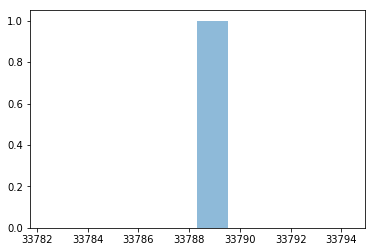

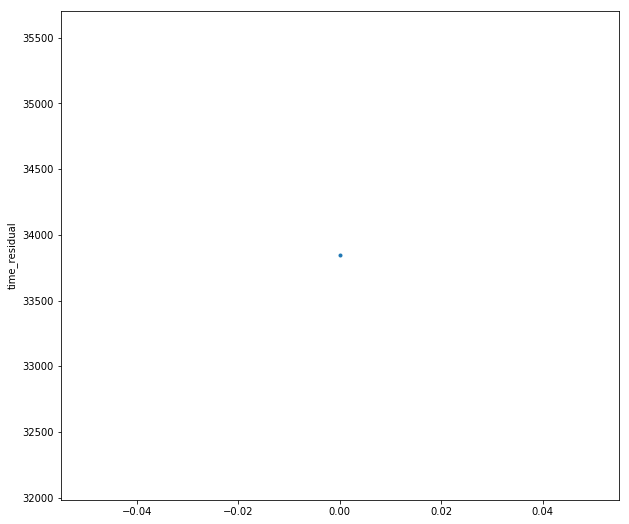

index_p 6
Jump Indices 11 12
1


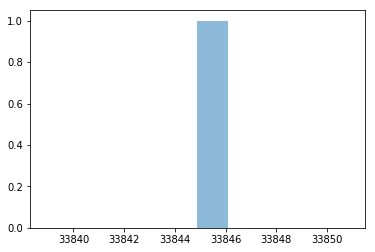

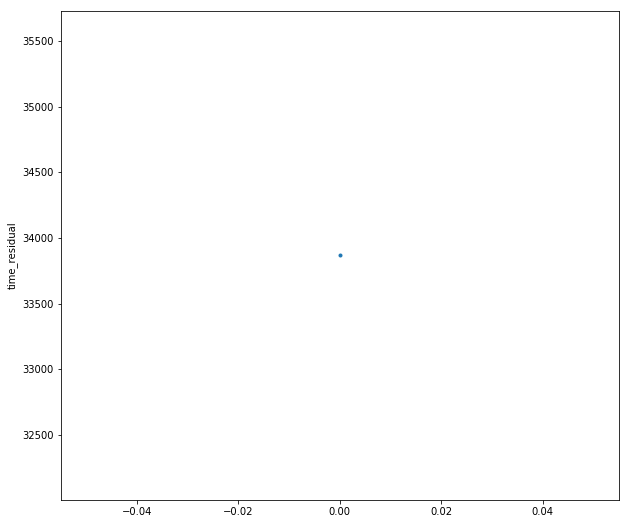

index_p 7
Jump Indices 12 13
1


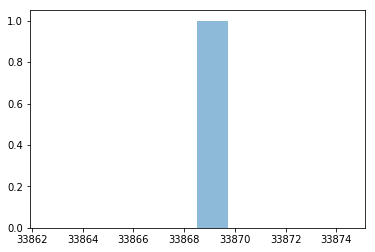

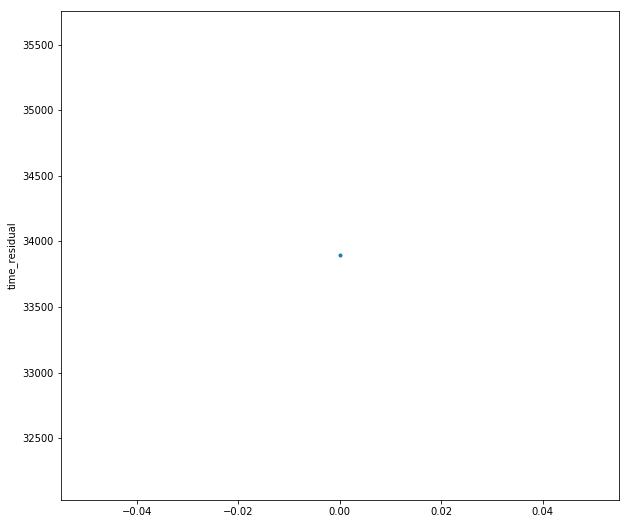

index_p 8
Jump Indices 13 15
2


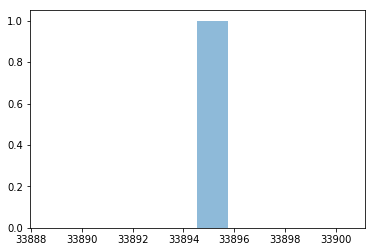

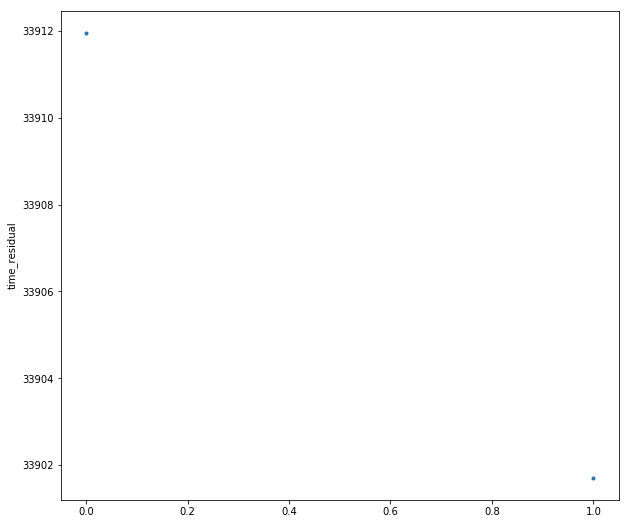

index_p 9
Jump Indices 15 16
1


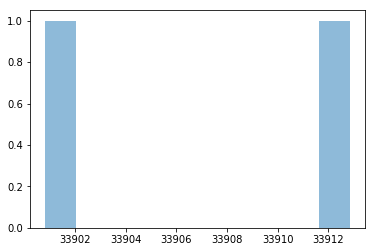

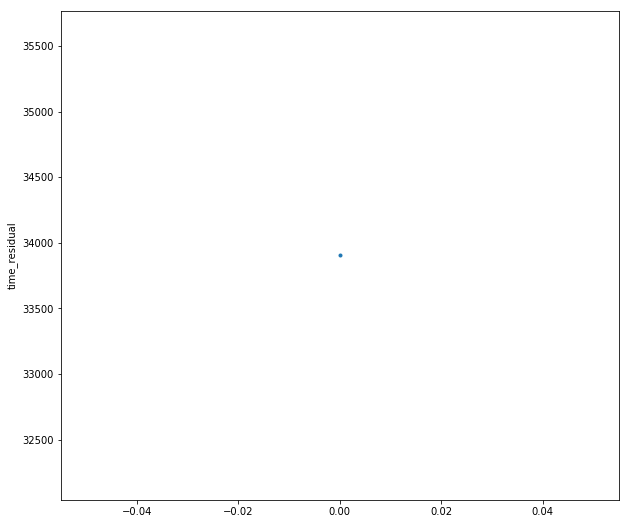

index_p 10
Jump Indices 16 18
2


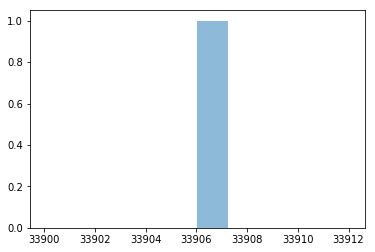

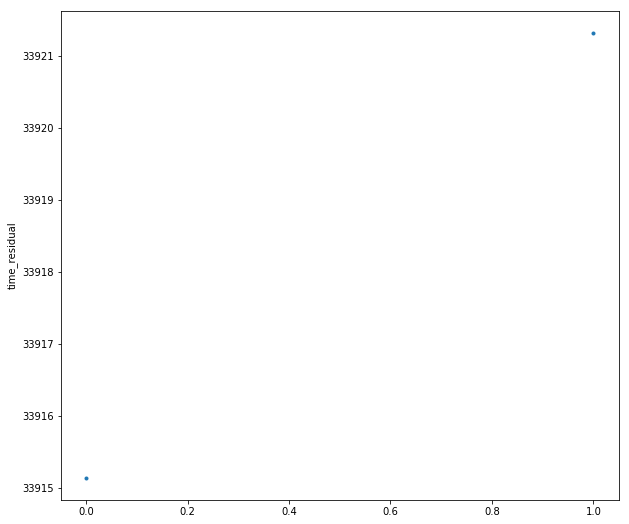

index_p 11
Jump Indices 18 22
4


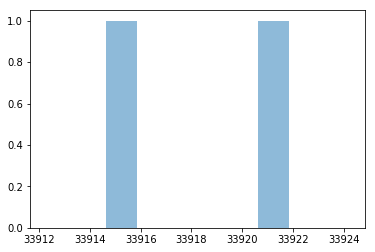

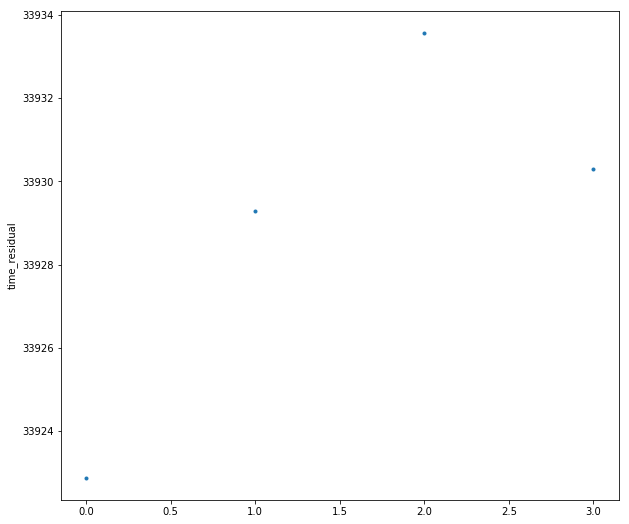

index_p 12
Jump Indices 22 23
1


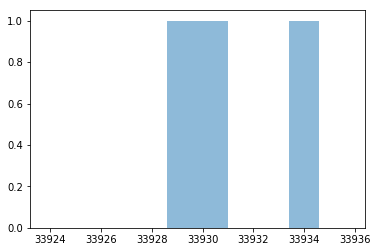

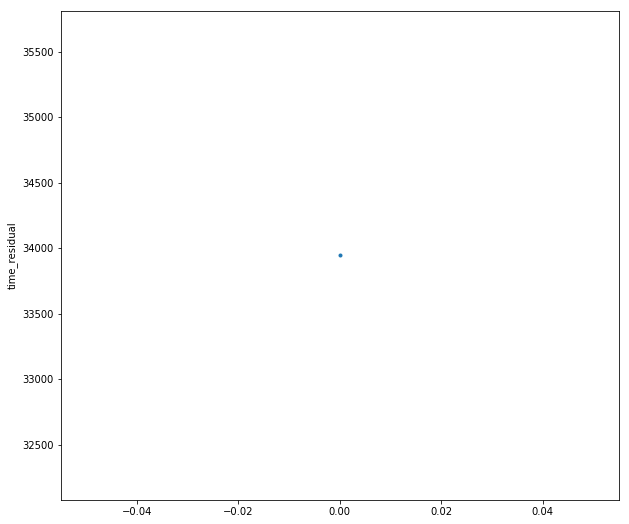

index_p 13
Jump Indices 23 24
1


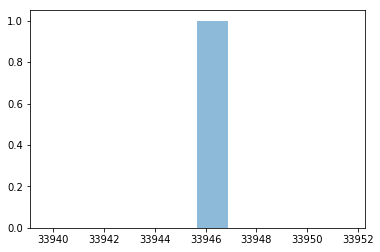

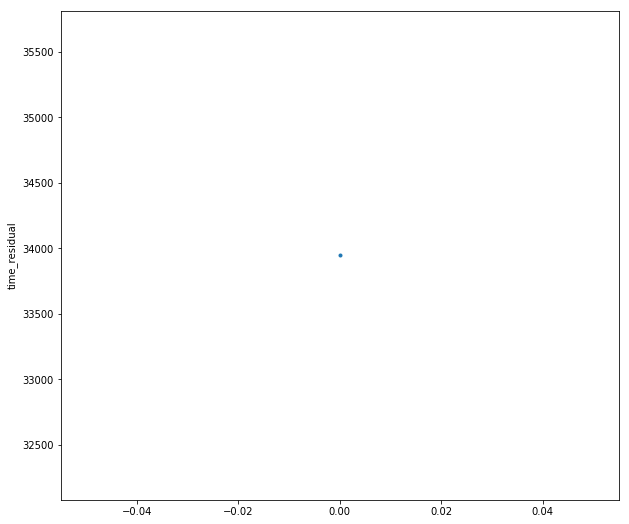

index_p 14
Jump Indices 24 25
1


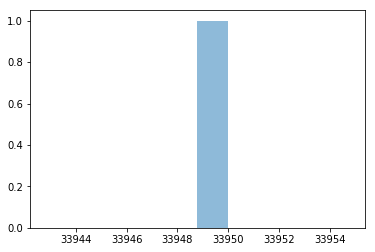

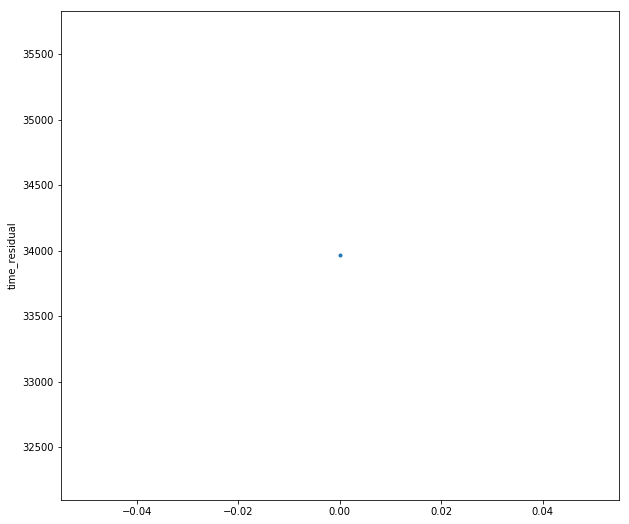

index_p 15
Jump Indices 25 26
1


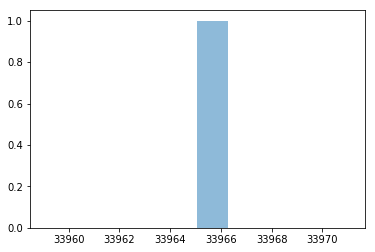

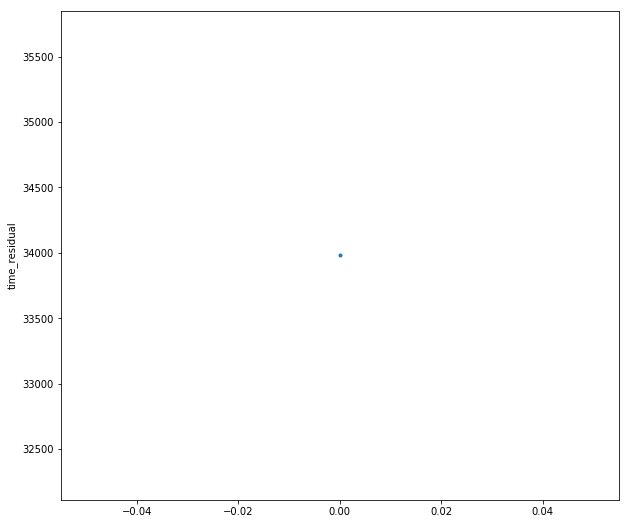

index_p 16
Jump Indices 26 27
1


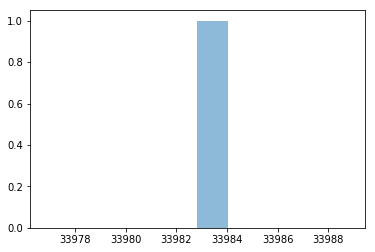

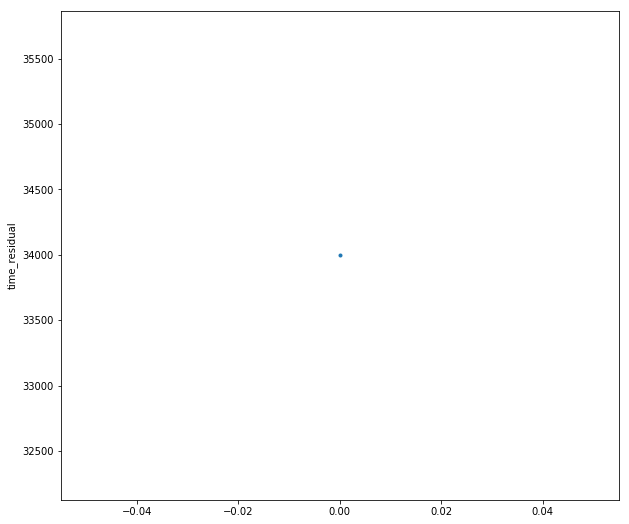

index_p 17
Jump Indices 27 28
1


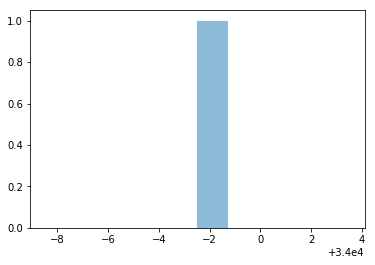

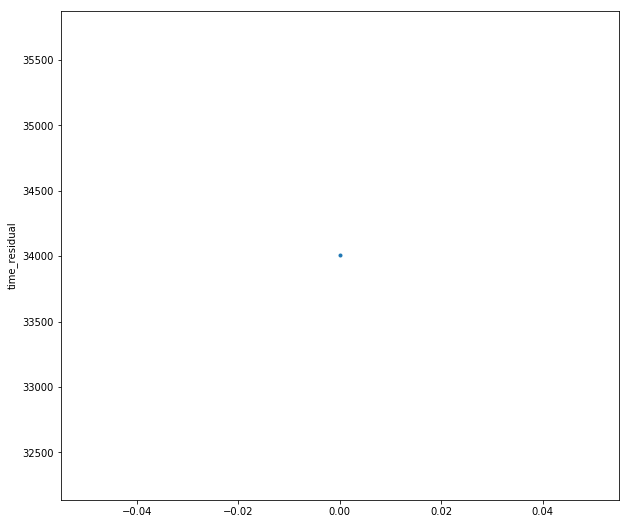

index_p 18
Jump Indices 28 29
1


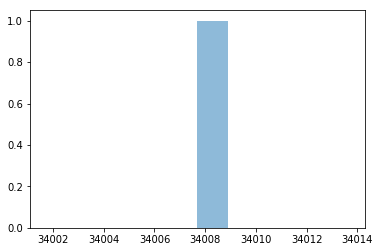

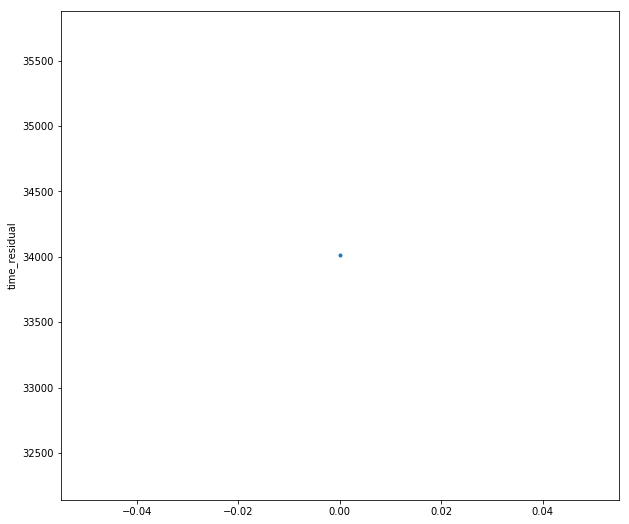

index_p 19
Jump Indices 29 33
4


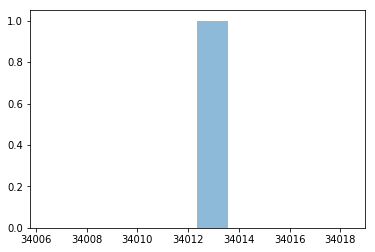

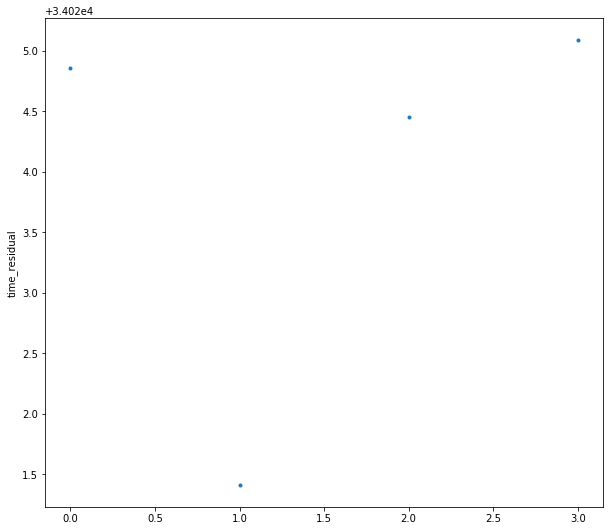

index_p 20
Jump Indices 33 39
6


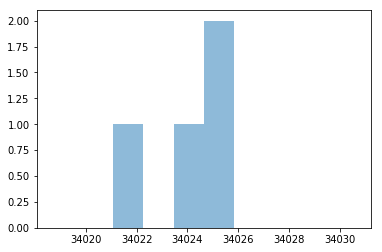

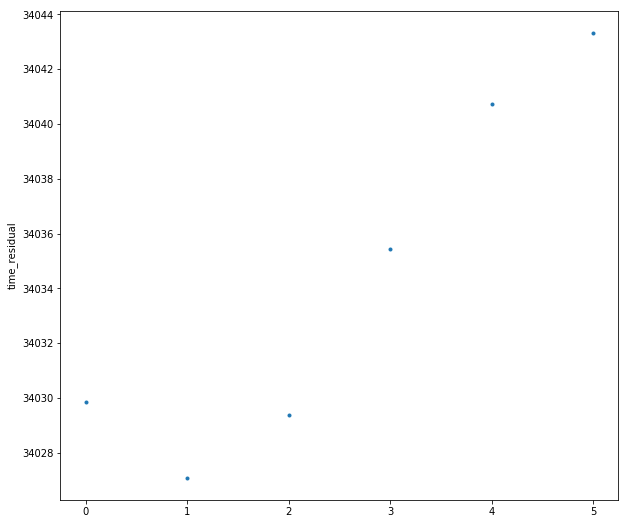

index_p 21
Jump Indices 39 41
2


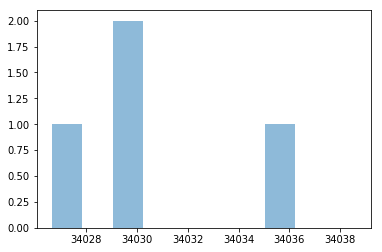

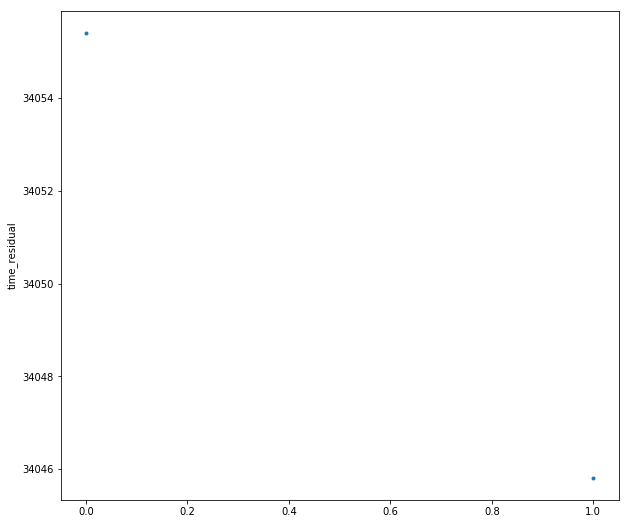

index_p 22
Jump Indices 41 42
1


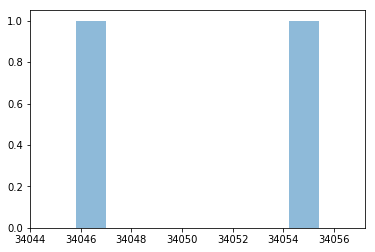

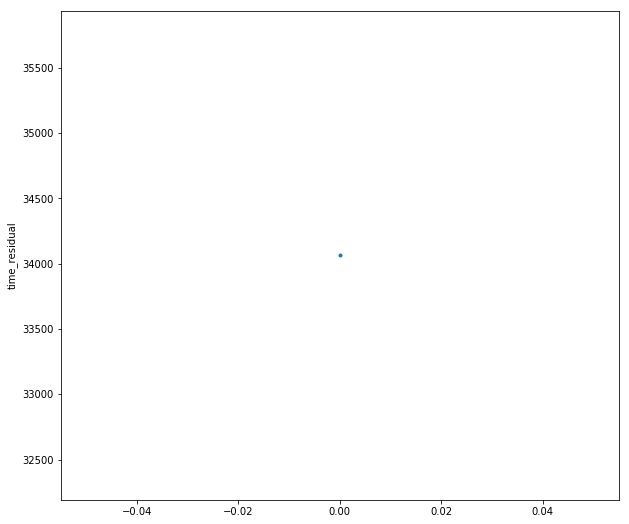

index_p 23
Jump Indices 42 43
1


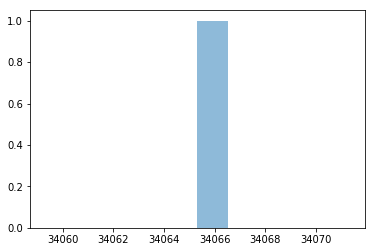

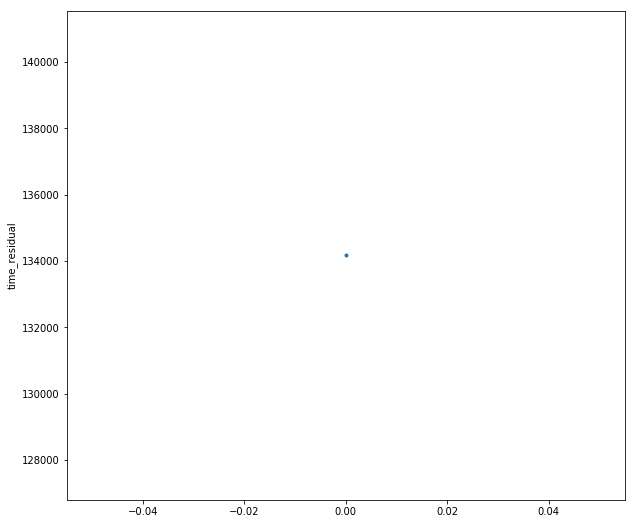

index_p 24
Jump Indices 43 44
1


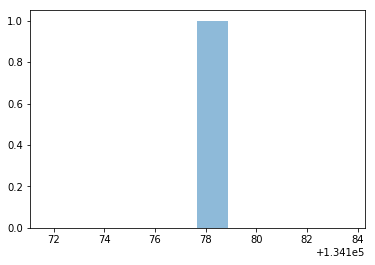

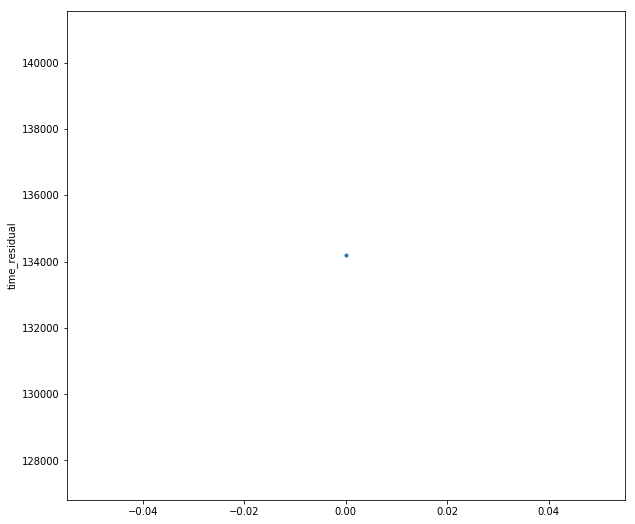

index_p 25
Jump Indices 44 45
1


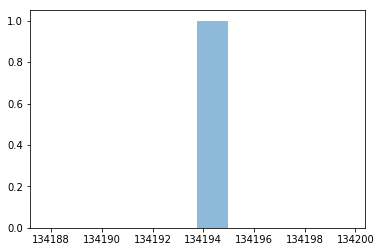

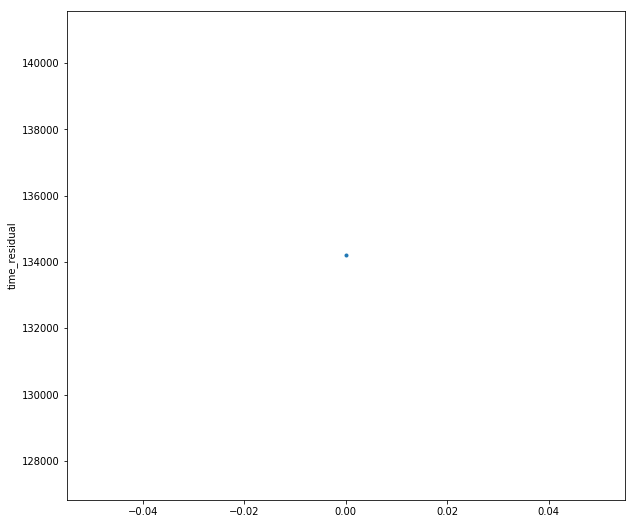

index_p 26
Jump Indices 45 46
1


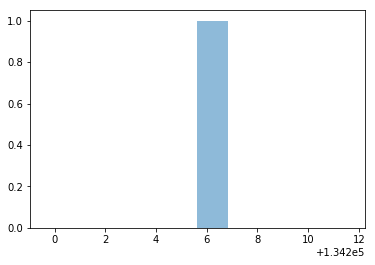

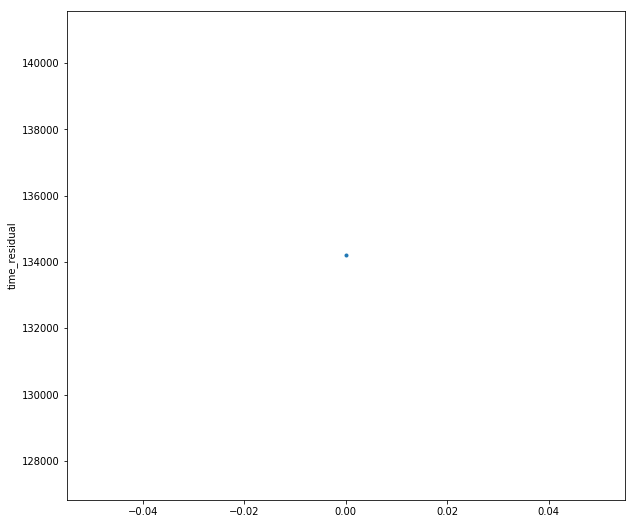

index_p 27
Jump Indices 46 47
1


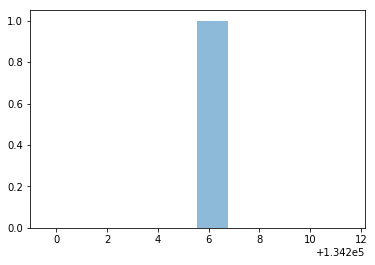

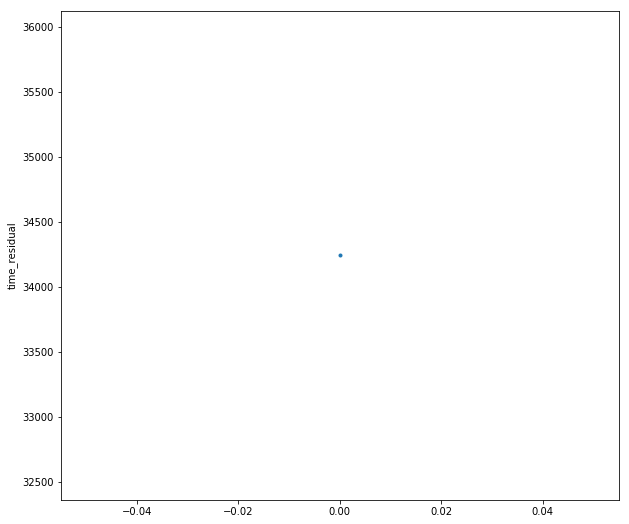

index_p 28
Jump Index size = 29 47
[47]
Jump Indices 47 47


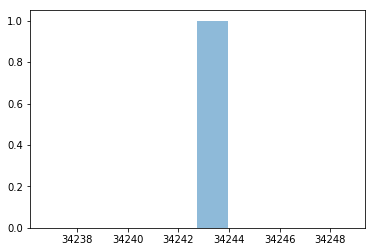

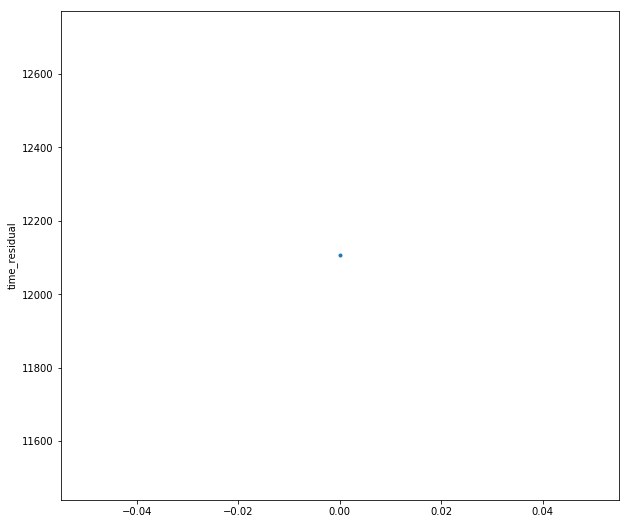

Closing remaining open files:/Users/cosmos2299/documents/data/20181205_092552_UTC_SDOM5_FLASH_SANTACLAUS_P2_violet_both_5000Hz_20V_60s_18339135919.hld_up.hdf5...done/Users/cosmos2299/documents/data/20181205_092552_UTC_SDOM2_FLASH_SANTACLAUS_P2_violet_both_5000Hz_20V_60s_18339135919.hld_up.hdf5...done/Users/cosmos2299/documents/data/20181205_092552_UTC_SDOM1_FLASH_SANTACLAUS_P2_violet_both_5000Hz_20V_60s_18339135919.hld_up.hdf5...done


In [ ]:
num_events3, est_res_diff, t_res_all1, what_peak, noise_events3 = r3.res(30, 6)

[  1   2   3   4   5   7   8   9  10  11  14  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 25

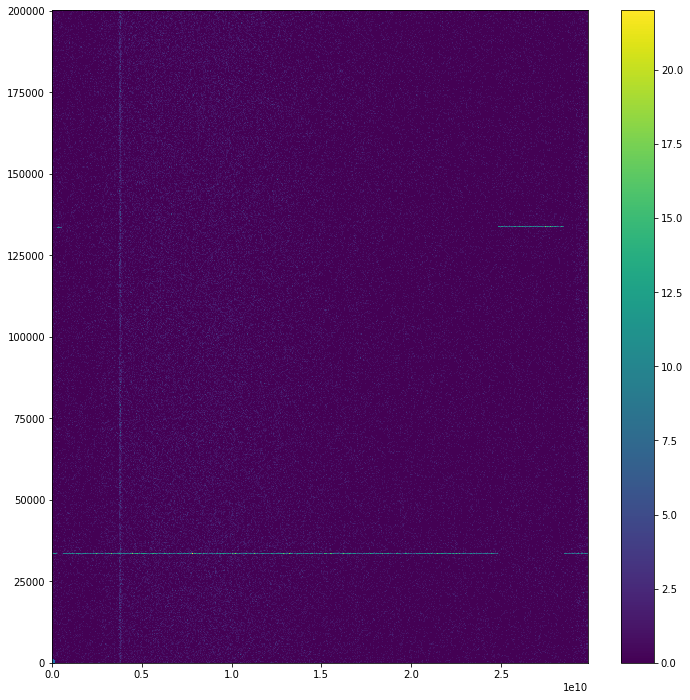

In [29]:
abs_elim, BinsHist, JumpIndex, xedges, yedges, POCAM_bins, POCAM_diff = HIST2D(625)

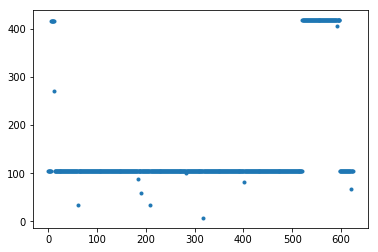

In [30]:
plt.plot(POCAM_bins, '.')

run# 0
b 1 Max 1
select size 145
median -  33638.58561654907
a 1 1 min
run# 1
b 2 Max 2
select size 115
median -  33636.873824537965
a 2 2 min
run# 2
b 3 Max 3
select size 133
median -  33638.21348041721
a 3 3 min
run# 3
b 4 Max 4
select size 124
median -  33648.0959189588
a 4 4 min
run# 4
b 5 Max 5
select size 119
median -  33636.52537572375
a 5 5 min
run# 5
b 7 Max 7
select size 265
run# 6
b 8 Max 8
select size 377
median -  99993.41552775243
a 8 8 min
run# 7
b 9 Max 9
select size 129
median -  133735.5693326447
a 9 9 min
run# 8
b 10 Max 10
select size 133
median -  133735.09751638136
a 10 10 min
run# 9
b 11 Max 11
select size 129
median -  133736.4879645781
a 11 11 min
run# 10
b 14 Max 14
select size 351
median -  84641.79488894885
a 14 14 min
run# 11
b 15 Max 15
select size 131
median -  33738.036451310676
a 15 15 min
run# 12
b 16 Max 16
select size 113
median -  33759.214013862074
a 16 16 min
run# 13
b 17 Max 17
select size 135
median -  33753.141775503405
a 17 17 min
run# 14
b 18

a 124 124 min
run# 119
b 125 Max 125
select size 257
median -  33743.17328033061
a 125 125 min
run# 120
b 126 Max 126
select size 257
median -  33752.18580550226
a 126 126 min
run# 121
b 127 Max 127
select size 269
median -  33743.61078818963
a 127 127 min
run# 122
b 128 Max 128
select size 263
median -  33746.37320935348
a 128 128 min
run# 123
b 129 Max 129
select size 259
median -  33738.101835929905
a 129 129 min
run# 124
b 130 Max 130
select size 258
median -  33741.73414580367
a 130 130 min
run# 125
b 131 Max 131
select size 256
median -  33741.30328617542
a 131 131 min
run# 126
b 132 Max 132
select size 246
median -  33741.40578749485
a 132 132 min
run# 127
b 133 Max 133
select size 237
median -  33745.82504701358
a 133 133 min
run# 128
b 134 Max 134
select size 247
median -  33746.00364713892
a 134 134 min
run# 129
b 135 Max 135
select size 238
median -  33767.412460294785
a 135 135 min
run# 130
b 136 Max 136
select size 245
median -  33742.00090141679
a 136 136 min
run# 131
b 1

a 235 235 min
run# 226
b 236 Max 236
select size 217
median -  33751.107118823915
a 236 236 min
run# 227
b 237 Max 237
select size 233
median -  33742.88276253699
a 237 237 min
run# 228
b 238 Max 238
select size 203
median -  33744.12162247955
a 238 238 min
run# 229
b 239 Max 239
select size 231
median -  33742.25812939924
a 239 239 min
run# 230
b 240 Max 240
select size 196
median -  33755.29657512673
a 240 240 min
run# 231
b 241 Max 241
select size 215
median -  33747.0758897191
a 241 241 min
run# 232
b 242 Max 242
select size 224
median -  33746.584906470816
a 242 242 min
run# 233
b 243 Max 243
select size 230
median -  33742.93862344633
a 243 243 min
run# 234
b 244 Max 244
select size 206
median -  33744.808664898126
a 244 244 min
run# 235
b 245 Max 245
select size 233
median -  33743.71708691187
a 245 245 min
run# 236
b 246 Max 246
select size 219
median -  33747.32008427975
a 246 246 min
run# 237
b 247 Max 247
select size 209
median -  33744.24503295915
a 247 247 min
run# 238
b 2

a 339 339 min
run# 328
b 340 Max 340
select size 132
median -  33747.988269974216
a 340 340 min
run# 329
b 341 Max 341
select size 137
median -  33748.07074495498
a 341 341 min
run# 330
b 342 Max 342
select size 146
median -  33752.1572358635
a 342 342 min
run# 331
b 343 Max 343
select size 125
median -  33759.1633813426
a 343 343 min
run# 332
b 344 Max 344
select size 122
median -  33749.99887451483
a 344 344 min
run# 333
b 345 Max 345
select size 118
median -  33745.85462541948
a 345 345 min
run# 334
b 346 Max 346
select size 137
median -  33745.81105930428
a 346 346 min
run# 335
b 347 Max 347
select size 146
median -  33746.5697007821
a 347 347 min
run# 336
b 348 Max 348
select size 139
median -  33746.21918685277
a 348 348 min
run# 337
b 349 Max 349
select size 148
median -  33770.36610702137
a 349 349 min
run# 338
b 350 Max 350
select size 110
median -  33744.11261052021
a 350 350 min
run# 339
b 351 Max 351
select size 139
median -  33746.079917079885
a 351 351 min
run# 340
b 352 

a 442 442 min
run# 431
b 443 Max 443
select size 96
median -  33754.140576766105
a 443 443 min
run# 432
b 444 Max 444
select size 111
median -  33753.25114232034
a 444 444 min
run# 433
b 445 Max 445
select size 120
median -  33753.06771782023
a 445 445 min
run# 434
b 446 Max 446
select size 119
median -  33749.49107435724
a 446 446 min
run# 435
b 447 Max 447
select size 98
median -  33748.96997239272
a 447 447 min
run# 436
b 448 Max 448
select size 93
median -  33774.350744267926
a 448 448 min
run# 437
b 449 Max 449
select size 100
median -  33752.631019713765
a 449 449 min
run# 438
b 450 Max 450
select size 109
median -  33753.389410131786
a 450 450 min
run# 439
b 451 Max 451
select size 102
median -  33748.113983527146
a 451 451 min
run# 440
b 452 Max 452
select size 93
median -  33752.21092696005
a 452 452 min
run# 441
b 453 Max 453
select size 118
median -  33751.958006046974
a 453 453 min
run# 442
b 454 Max 454
select size 117
median -  33751.11047736512
a 454 454 min
run# 443
b 4

a 545 545 min
run# 533
b 546 Max 546
select size 115
median -  133852.64522114134
a 546 546 min
run# 534
b 547 Max 547
select size 94
median -  133856.89579701115
a 547 547 min
run# 535
b 548 Max 548
select size 94
median -  133856.4679587049
a 548 548 min
run# 536
b 549 Max 549
select size 87
median -  133872.14488398857
a 549 549 min
run# 537
b 550 Max 550
select size 97
median -  133854.9639135237
a 550 550 min
run# 538
b 551 Max 551
select size 105
median -  133860.5301282661
a 551 551 min
run# 539
b 552 Max 552
select size 100
median -  133853.8371861928
a 552 552 min
run# 540
b 553 Max 553
select size 118
median -  133850.00250169402
a 553 553 min
run# 541
b 554 Max 554
select size 102
median -  133851.94223685114
a 554 554 min
run# 542
b 555 Max 555
select size 103
median -  133847.57408649835
a 555 555 min
run# 543
b 556 Max 556
select size 100
median -  133860.5836519944
a 556 556 min
run# 544
b 557 Max 557
select size 118
median -  133852.20278480928
a 557 557 min
run# 545
b 

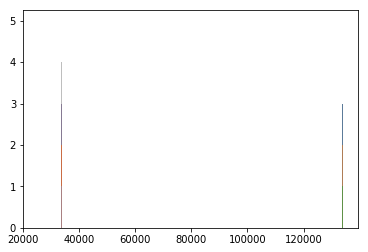

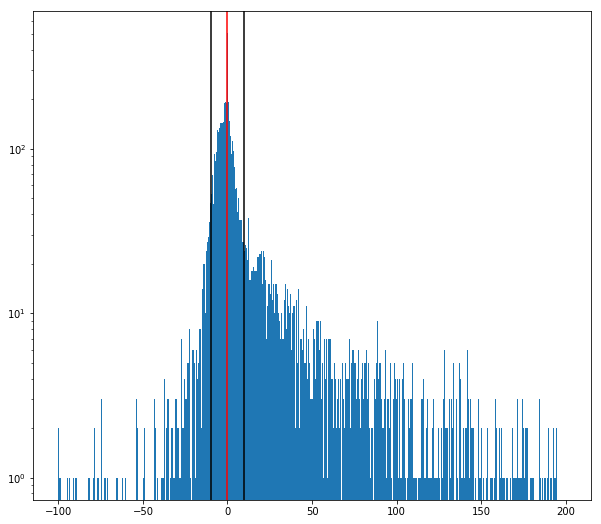

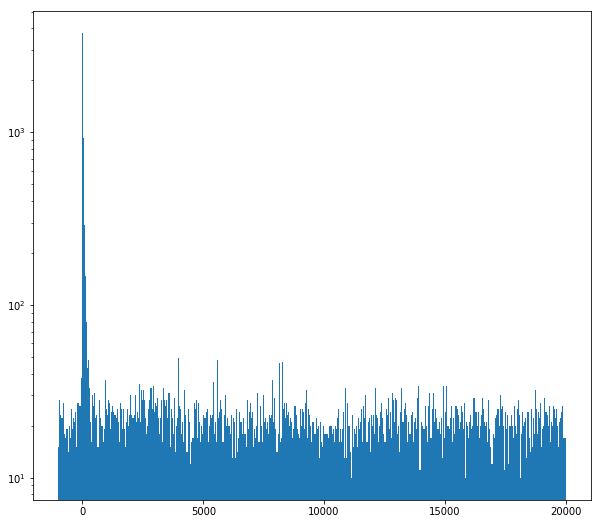

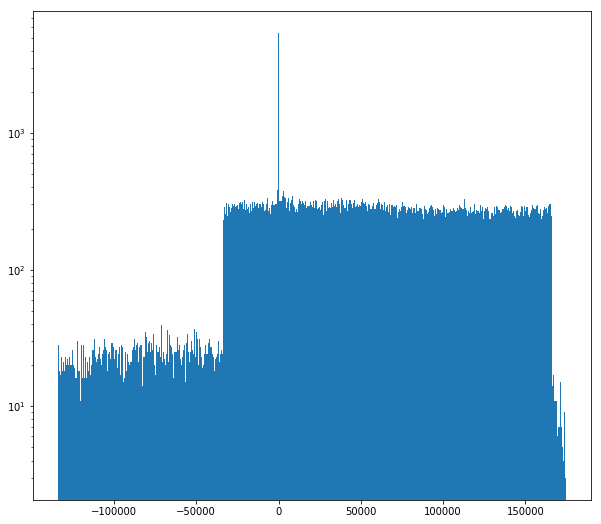

In [31]:
t_res_all3, peak_1, num_events3 = calc_res(10, 2, 1)

In [32]:
RunTime3, error_rtime3 = run_time(atstamp, p_jumps)

timestamp of the last event -  29836289711.757812
eliminating high jumps and summing -  29827964679.67187
run time -  29827964679.67187


In [33]:
distance3, angle_cr3 = angl_dist()

In [34]:
eve_p_sec3, error_nevents3 = correction(num_events3, angle_cr3, RunTime3)

In [35]:
eve_p_sec3

119.68234847388825

In [36]:
d = clean('20181205_092552_UTC_SDOM3_FLASH_SANTACLAUS_P2_violet_both_5000Hz_20V_60s_18339135919.hld_up.hdf5')

percentage of high jumps in the file - 0.0


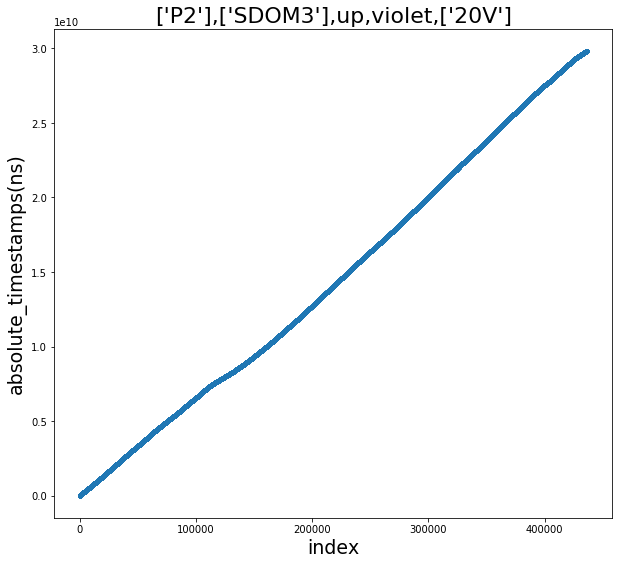

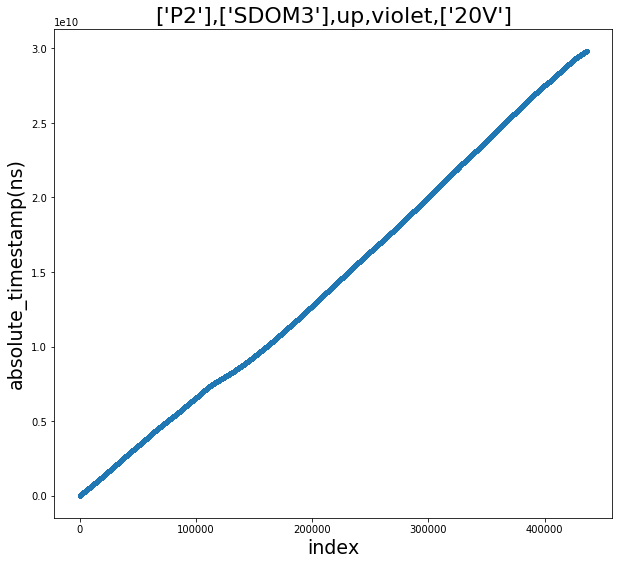

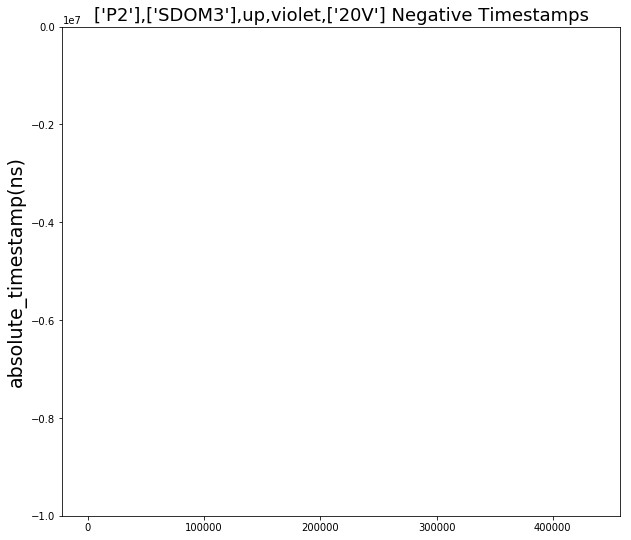

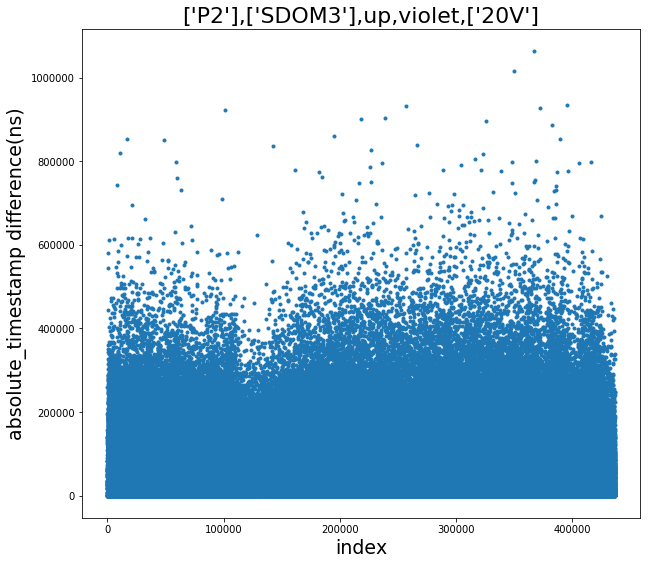

[]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:166: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:170: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:171: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:173: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the futur

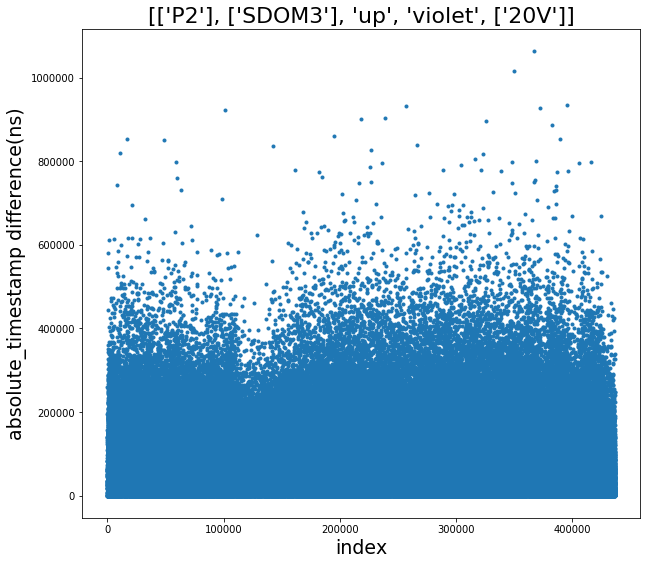

0.6987213952275575


In [37]:
(abs_elim_3, rising_0_elim_3, rising_1_elim_3, rising_2_elim_3, rising_3_elim_3,
falling_0_elim_3, falling_1_elim_3, falling_2_elim_3, falling_3_elim_3, POCAM_num, values,
atstamp, p_jumps, dt_mean, f_r, values, file_path, SDOM_num, PMT) = d.P_S_used()

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3507: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)


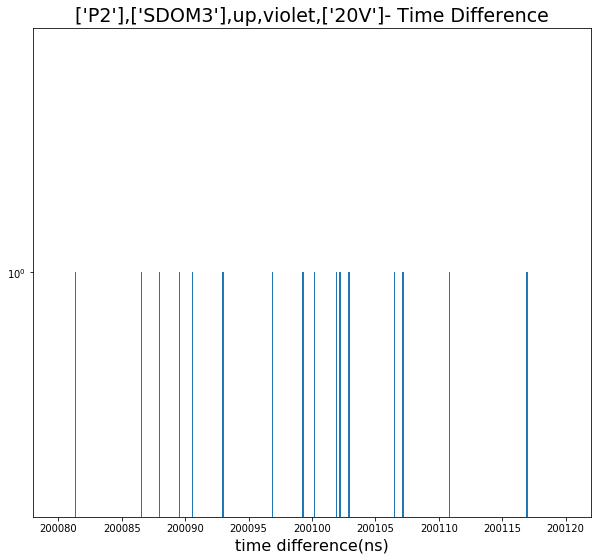

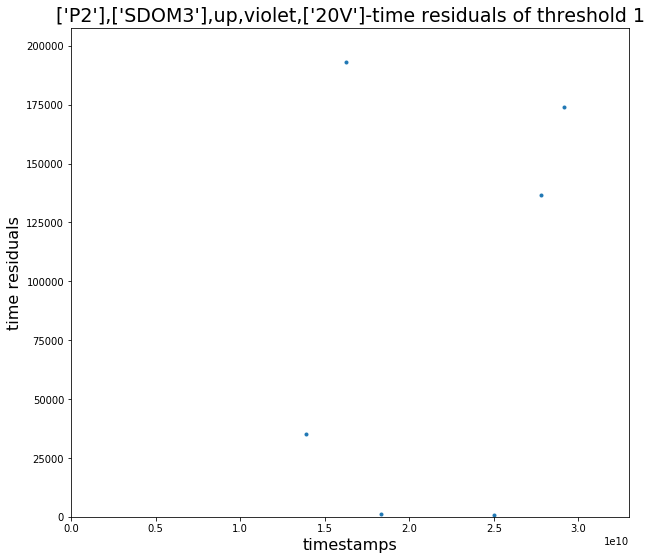

In [38]:
r4 = residual(rising_1_elim_3,200080, 200120, 400, 
                                200095, 200105,
             0.0e10,3.3e10,0, 207750)

[ 2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 49 53 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 74 75 76 78 80 81 82 83
 84 85 86 87 88 89 90 91 93 94 95 96 97 98 99]


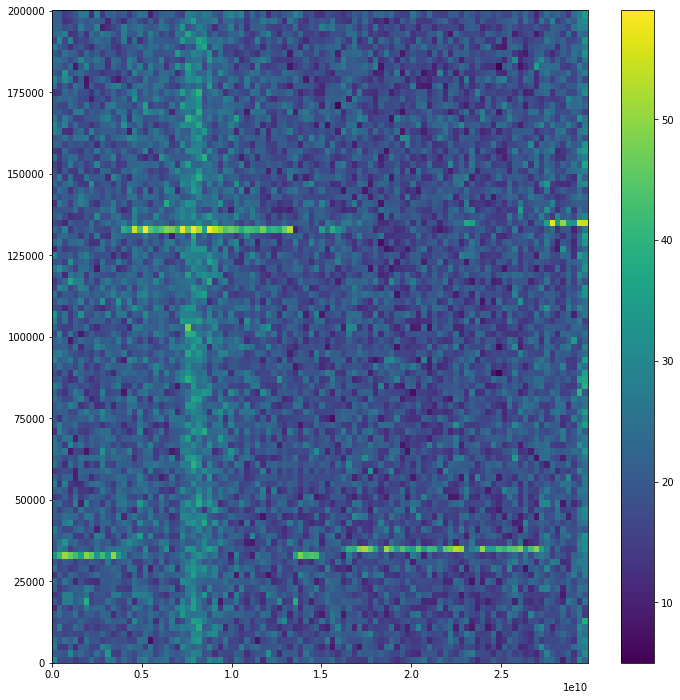

In [39]:
abs_elim, BinsHist, JumpIndex, xedges, yedges, POCAM_bins, POCAM_diff = HIST2D(100)

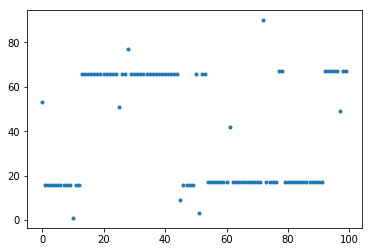

In [40]:
plt.plot(POCAM_bins, '.')

run# 0
b 2 Max 2
select size 4197
median -  67765.75260575343
a 2 2 min
run# 1
b 3 Max 3
select size 2060
median -  33751.89396201994
a 3 3 min
run# 2
b 4 Max 4
select size 1988
median -  33664.65806819586
a 4 4 min
run# 3
b 5 Max 5
select size 1957
median -  33625.1422416018
a 5 5 min
run# 4
b 6 Max 6
select size 2029
median -  33425.358115828305
a 6 6 min
run# 5
b 7 Max 7
select size 1970
median -  33322.05470819556
a 7 7 min
run# 6
b 8 Max 8
select size 1904
median -  33290.43420753535
a 8 8 min
run# 7
b 9 Max 9
select size 1939
median -  32622.314637738455
a 9 9 min
run# 8
b 10 Max 10
select size 2096
median -  33153.07180341697
a 10 10 min
run# 9
b 11 Max 11
select size 2014
run# 10
b 12 Max 12
select size 4060
median -  16152.222419830941
a 12 12 min
run# 11
b 14 Max 14
select size 4007
median -  81538.57701449329
a 14 14 min
run# 12
b 15 Max 15
select size 2047
median -  132917.4022814851
a 15 15 min
run# 13
b 16 Max 16
select size 2189
median -  133931.8988390572
a 16 16 min
ru

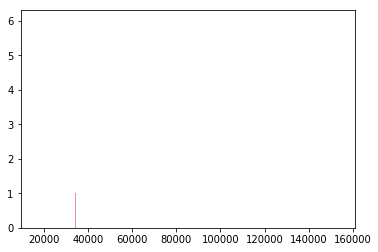

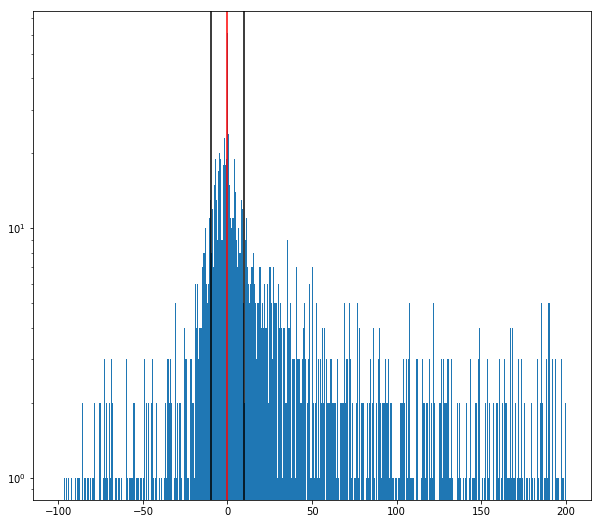

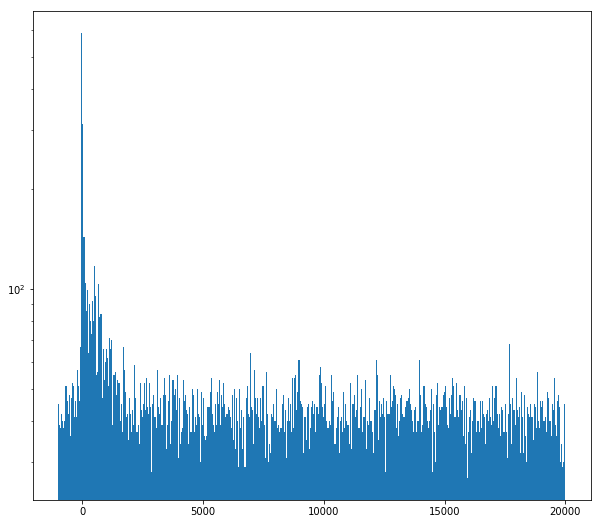

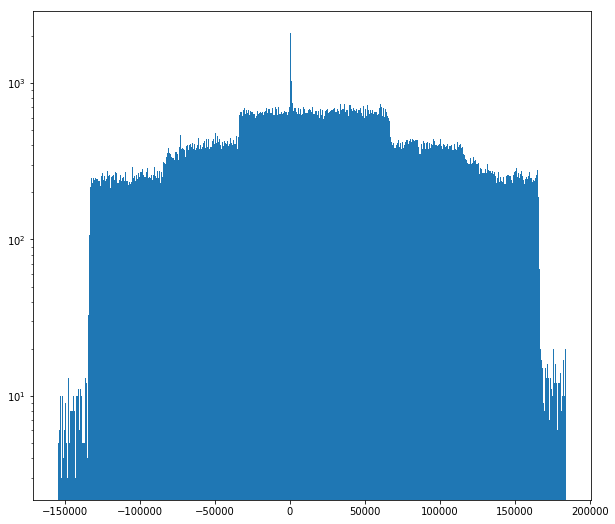

In [41]:
t_res_all4, peak_1, num_events4 = calc_res(10, 2, 2)

In [ ]:
num_events4, est_res_diff, t_res_all1, what_peak, noise_events4 = r4.res(30, 6)

In [42]:
RunTime4, error_rtime4 = run_time(atstamp, p_jumps)

timestamp of the last event -  29837158140.46875
eliminating high jumps and summing -  29829812723.70703
run time -  29829812723.70703


In [43]:
distance4, angle_cr4 = angl_dist()

In [44]:
eve_p_sec4, error_nevents4 = correction(num_events4, angle_cr4, RunTime4)

In [45]:
eve_p_sec4

15.867291819578567

In [46]:
eve_p_sec = np.array([eve_p_sec1, eve_p_sec2, eve_p_sec3, eve_p_sec4])
distance = np.array([distance1, distance2, distance3, distance4])

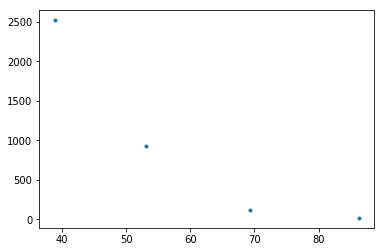

In [47]:
plt.plot(distance, eve_p_sec, '.')

In [48]:
sigg = np.array([eve_p_sec[0] * (np.sqrt((1/error_nevents1) + (error_rtime1/RunTime1)**2)), 
                eve_p_sec[1] *(np.sqrt((1/(error_nevents2)) + (error_rtime2/RunTime2)**2)),
                eve_p_sec[2] *((np.sqrt(1/(error_nevents3)) + (error_rtime3/RunTime3)**2)),
                eve_p_sec[3] *((np.sqrt(1/(error_nevents4)) + (error_rtime4/RunTime4)**2))])

In [49]:
def chi(N):
    chisq = np.sum(((eve_p_sec - ((N[0]/(distance**2))*np.exp(-distance/N[1])))/sigg)**2)
    return chisq

In [50]:
x0 = [10, 20]
par = minimize(chi,x0, method = 'Powell')

In [51]:
par.x[1]

17.276903781907965

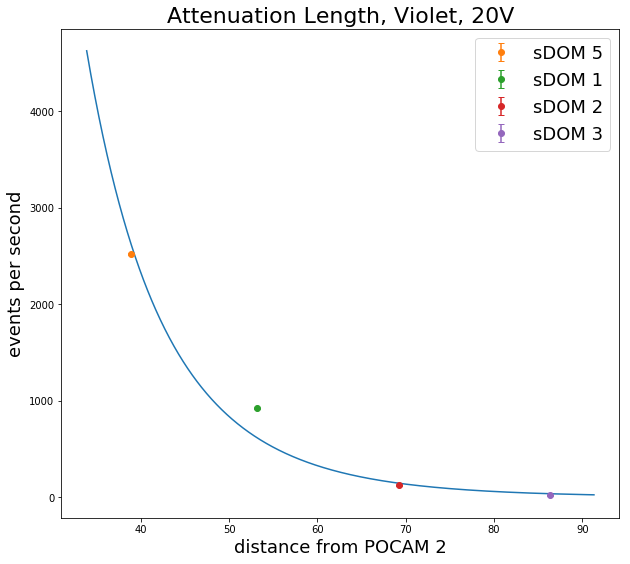

In [55]:
distance1 = np.linspace(distance.min() - 5, distance.max() + 5, 1000)
curve = (par.x[0]/(distance1**2)) * np.exp(-distance1/par.x[1])

plt.figure(figsize=(10,9))
plt.plot(distance1, curve)
#plt.plot(dist_set1, eve_w_angle, '.')
plt.errorbar(distance[0], eve_p_sec[0], yerr=sigg[0], fmt = 'o', markersize=6, capsize=3, label = 'sDOM 5')
plt.errorbar(distance[1], eve_p_sec[1], yerr=sigg[1], fmt = 'o', markersize=6, capsize=3, label = 'sDOM 1')
plt.errorbar(distance[2], eve_p_sec[2], yerr=sigg[2], fmt = 'o', markersize=6, capsize=3, label = 'sDOM 2')
plt.errorbar(distance[3], eve_p_sec[3], yerr=sigg[3], fmt = 'o', markersize=6, capsize=3, label = 'sDOM 3')
plt.legend(loc = 'best', fontsize = 18)
#plt.ylim(100, 200)
plt.xlabel('distance from POCAM 2', fontsize = 18)
plt.ylabel('events per second', fontsize = 18)
plt.title('Attenuation Length, Violet, 20V', fontsize = 22)   
plt.savefig(file_path + '/graphs/POCAM2, Violet, 20V, 5kHz' + 'attlength.jpeg', dpi = 200)

In [52]:
def CheckPeak():
    plt.figure(figsize=(10,9))
    for b in range(0, len(peak_1)):
        plt.figure(figsize=(10,9))
        n, bins, patches = plt.hist(peak_1[b], 
                                    #100, 
                                    np.linspace(-10, 200, 300),
                                    alpha = 0.5, log = True)
        #plt.axvline(x = 0, color = 'r')
        #plt.axvline(x = -10, color = 'k')
        #plt.axvline(x = 10, color = 'k')
    plt.title(values + '-time residuals of threshold 1', fontsize = 19)
    plt.xlabel('time_ns', fontsize = 16)
    plt.ylabel('bincount', fontsize = 16)

In [53]:
num_events1

80400

In [26]:
num_events2

78105